In [1]:
from IRDataAnal import *
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib as mpl

mpl.rcParams['axes.linewidth'] = 1.4
mpl.rcParams['axes.spines.top'] = False
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.bottom'] = True
plt.rcParams["axes.labelweight"] = "bold"
mpl.rcParams['axes.spines.left'] = True

mpl.rcParams['figure.dpi'] = 400

mpl.rcParams['font.size'] = 8
mpl.rcParams["font.weight"] = "bold"

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pathlib import Path
import copy 

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.cross_decomposition import PLSRegression
from sklearn.linear_model import Ridge

from sklearn.metrics import r2_score, mean_absolute_error
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel

import itertools
from sklearn.metrics import mean_absolute_error

In [5]:
import pymc as pm
import arviz as az
from pymc import HalfCauchy, Model, Normal, sample, HalfNormal, model_to_graphviz
import xarray as xr
from sklearn.neighbors import KernelDensity

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [6]:
from colour import Color
clist = ['b', 'orange', 'g', 'r', 'm', 'brown', 'cyan']

In [23]:
data = pd.read_excel('HPLC data/ac95-103 lc data.xlsx')

In [24]:
peakarea = data['peak area']

([], [])

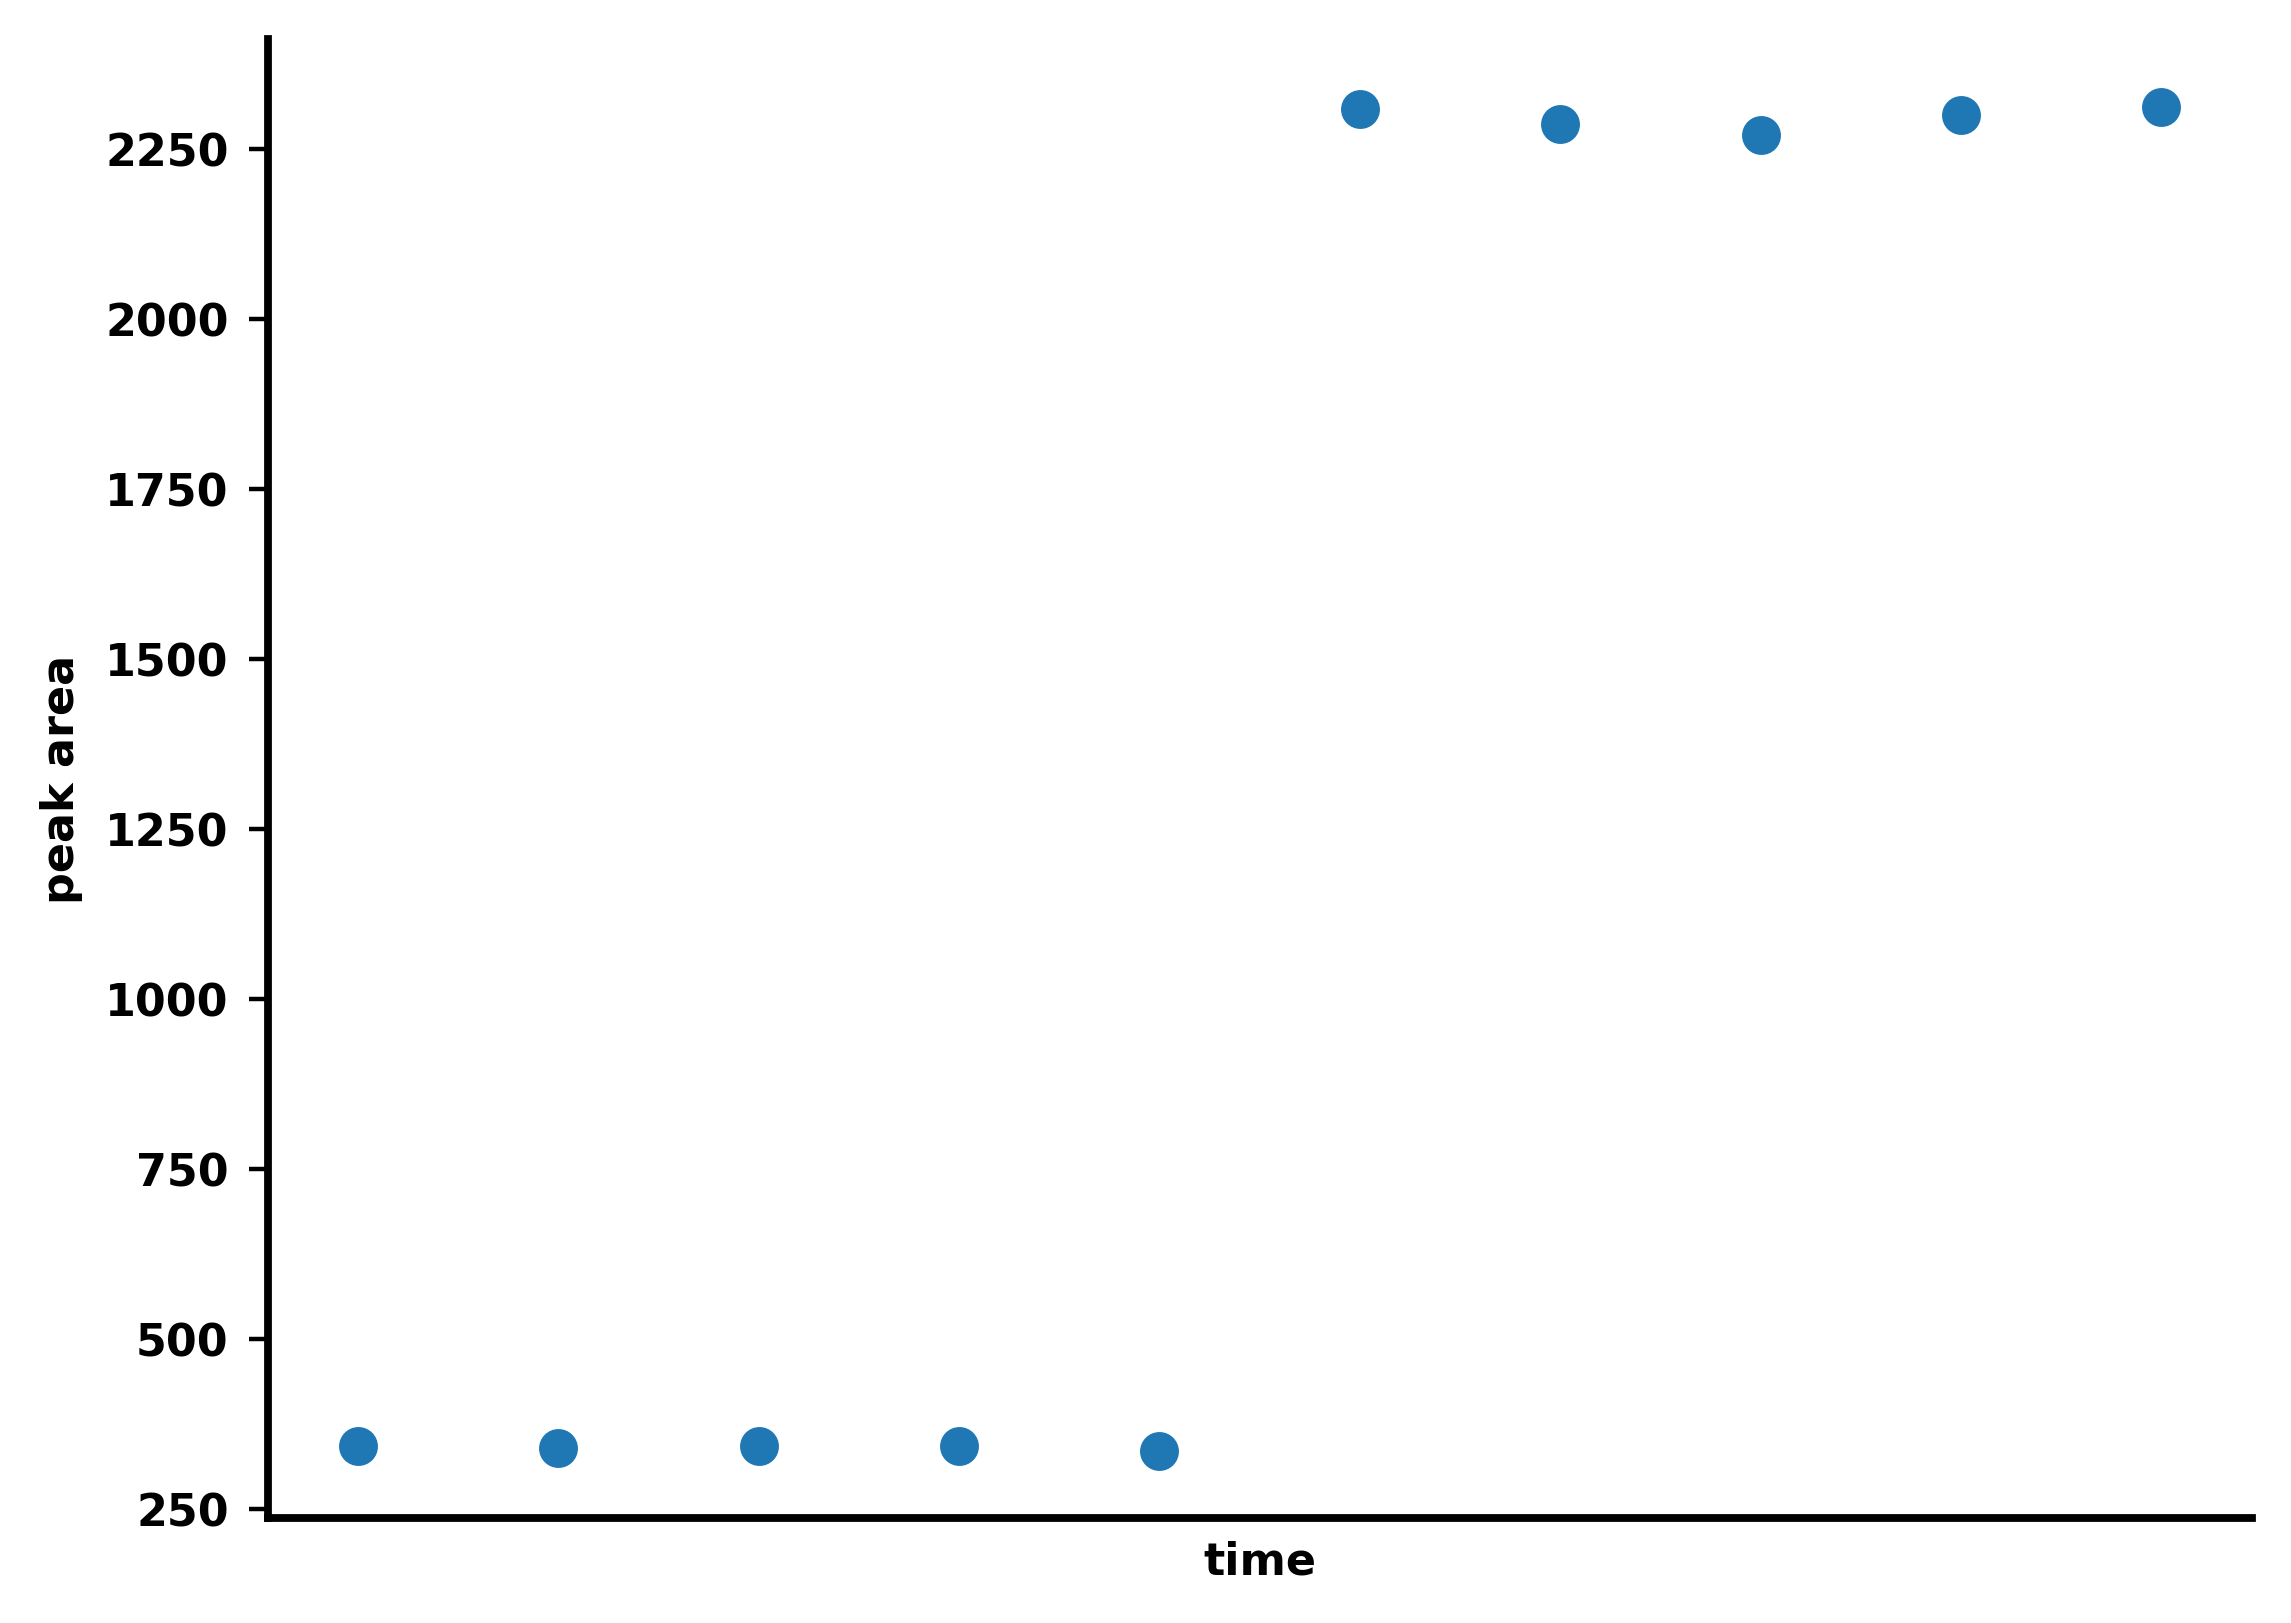

In [32]:
plt.scatter([i for i in range(10)], peakarea[[0,1,2,3,4,15, 16, 17,18,19]])
plt.xlabel('time')
plt.ylabel('peak area')
plt.xticks([])

# Load data

In [7]:
ir = calibrationData(raw_ir_dir='../hplc and IR data/IR data/', lc_dir='../hplc and IR data/HPLC data for training/', comp_names=['prod'])

Loading IR data......
ac0089-1
ac0089-2
ac0089-3
ac0091-1
ac0091-2
ac0091-4
ac0091-5
Loading LC data......
ac0089-1.xlsx
ac0089-2.xlsx
ac0089-3.xlsx
ac0091-1.xlsx
ac0091-2.xlsx
ac0091-4.xlsx
ac0091-5.xlsx


In [8]:
range_ = [[445], [475]]  # candidate 1
subtract_list = [14,13,10,8,10,11,13]

ir.preprocess(range_[0], range_[1], isTruncateData=False, isSubtractAny=subtract_list, isSNV=False, isDerivative=2,
              truncateWaveNUmber=None, skip=False, isSmooth=None)

In [9]:
ir.raw_ir_data_preprocess.shape

(202, 30)

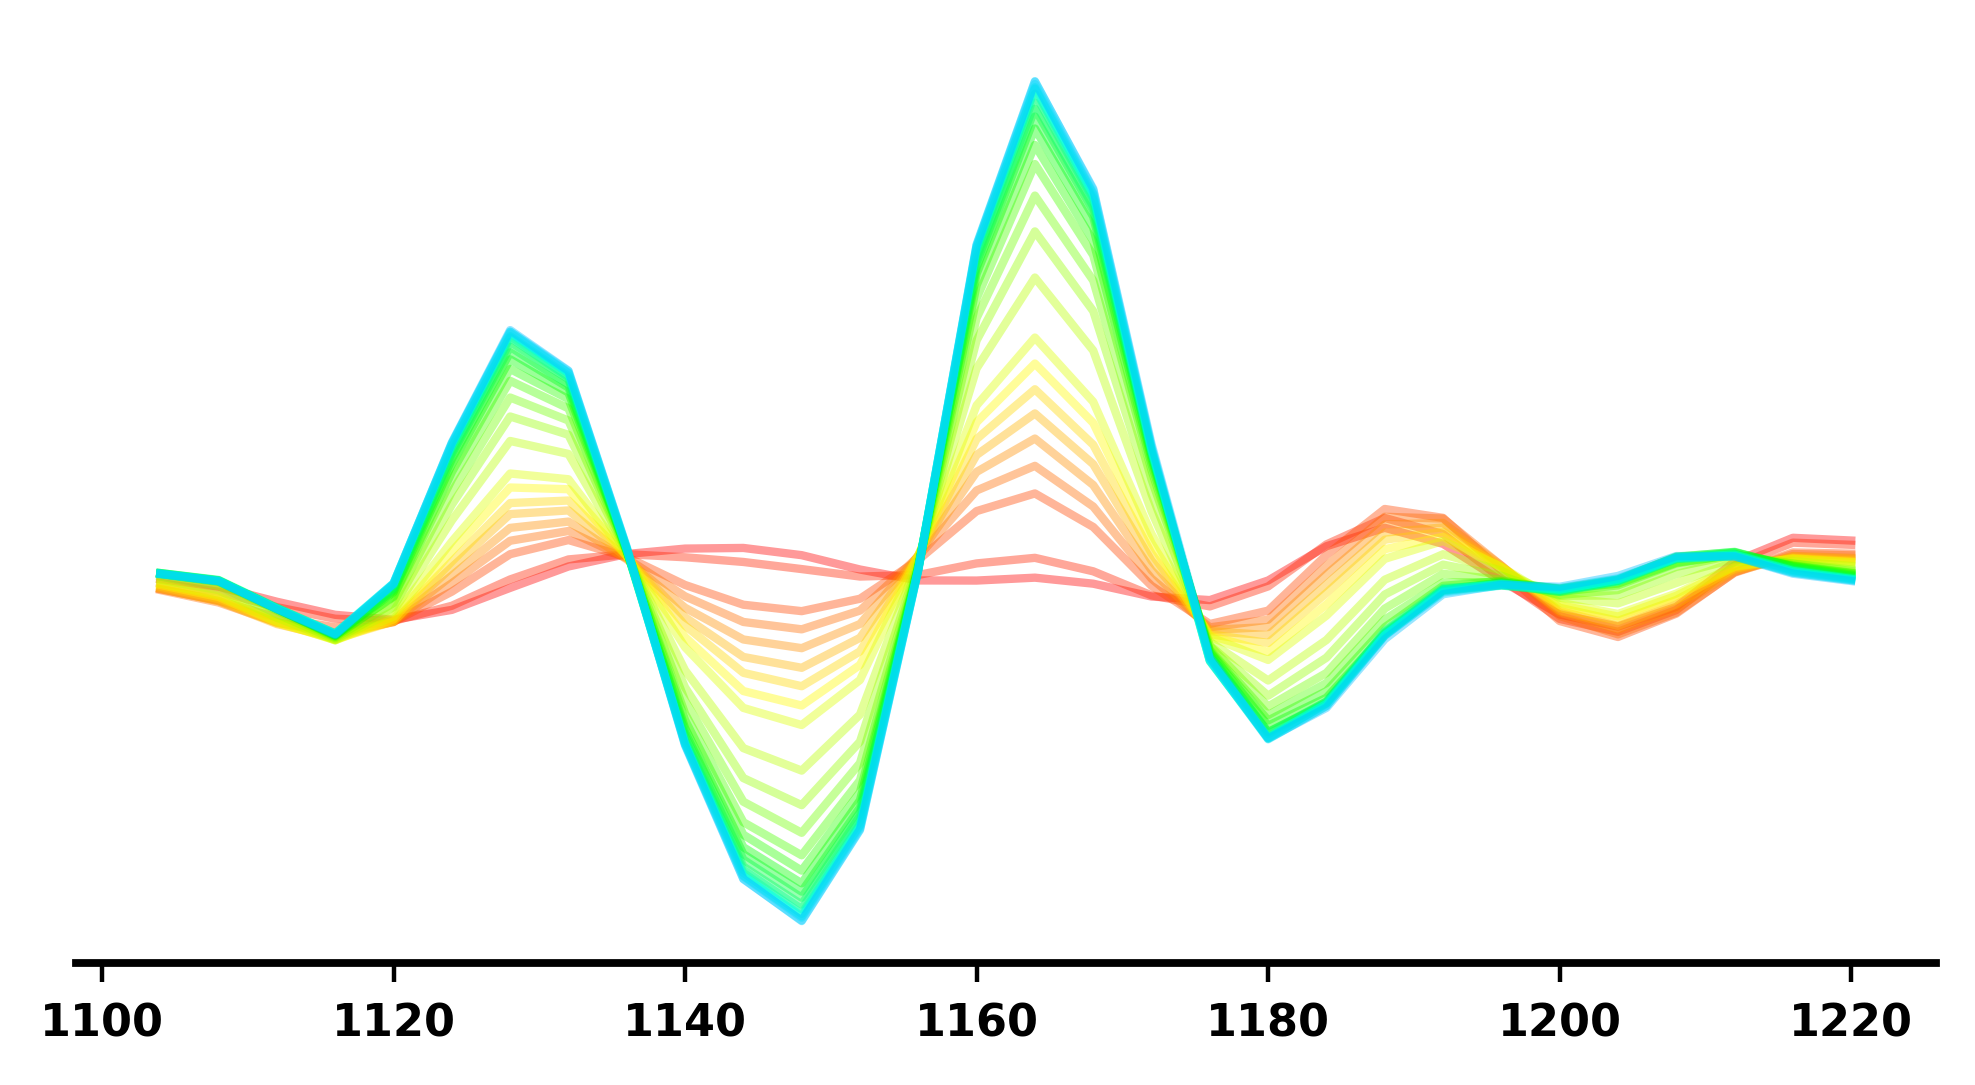

In [10]:
# plotting IR overlay of individual experiment

mpl.rcParams['axes.spines.left'] = False

plt.figure(figsize=(6, 3))

ind = 2
s, e = int(np.sum(ir.new_dataLList[:ind])), int(np.sum(ir.new_dataLList[:ind+1]))


red = Color("red")
colors = list(red.range_to(Color("deepskyblue"),e-s))
blue = Color("navy")
c2 = list(blue.range_to(Color("blue"),e-s))

for i in range(e-s): 
    plt.plot(ir.wave_number_preprocess[::-1], ir.raw_ir_data_preprocess[s:e, :][i], c=colors[i].get_rgb(), alpha=0.4)
plt.yticks([])
mpl.rcParams['axes.spines.left'] = True

In [9]:
# create ir trend list from loaded ir data using user defined method
s, e = 0, ir.new_dataLList[0]
trend_list = []

for i in range(len(ir.new_dataLList)): 

    temp_abs = ir.raw_ir_data_preprocess[s:e, :]
    temp_trend = []
    
    for j in range(temp_abs.shape[0]):
        spec = np.hstack((ir.wave_number_preprocess[:, np.newaxis], temp_abs[j, :][:, np.newaxis]))
        # temp_trend.append(heightToZero(spec))
        temp_trend.append(heightTwoPoints(0, -1, spec))

    trend_list.append(temp_trend)

    s = e
    if i == len(ir.new_dataLList) - 1: 
        e = -1
    else: 
        e = e + ir.new_dataLList[i+1]

In [38]:
# put lc data and ir trend into calibration format

lc_conversion_factor = 9.009e-5

s, e = 0, ir.new_dataLList[0]

all_cal_data = []

for i in range(len(ir.new_dataLList)): 

    all_cal_data.append([ir.lc_data[s:e, :]*lc_conversion_factor, trend_list[i]])

    s = e
    if i == len(ir.new_dataLList) - 1: 
        e = -1
    else: 
        e = e + ir.new_dataLList[i+1]

In [46]:
# grab global max and min from lc and ir data

x_all, y_all = [], []
for i in range(len(all_cal_data)): 

    x_all.append(all_cal_data[i][1])
    y_all.append(all_cal_data[i][0])

x_all, y_all = np.concatenate(x_all), np.concatenate(y_all)

In [81]:
# old, load ir trends from icir trend 
ir_data_path = 'prodIR/'
lc_data_path = 'prodLC/'

In [82]:
entries = Path(ir_data_path)
ir_data = []
for entry in sorted(entries.iterdir()): 
    
    if entry.name[0] == '.': 
        continue
    
    print(entry.name)
    
    
    ir_data.append(pd.read_excel(ir_data_path + entry.name))
    
# load lc data
entries = Path(lc_data_path)
lc_data = []

for entry in sorted(entries.iterdir()): 

    if entry.name[0] == '.': 
        continue
    
    print(entry.name)
    
    lc_data.append(pd.read_excel(lc_data_path + entry.name))

ac0089-1 prodIR.xlsx
ac0089-2 prodIR.xlsx
ac0089-3 prodIR.xlsx
ac0091-1 prodIR.xlsx
ac0091-2 prodIR.xlsx
ac0091-4 prodIR.xlsx
ac0091-5 prodIR.xlsx
ac0089-1.xlsx
ac0089-2.xlsx
ac0089-3.xlsx
ac0091-1.xlsx
ac0091-2.xlsx
ac0091-4.xlsx
ac0091-5.xlsx


In [159]:
all_cal_data = []
all_lc_time = []

for i in range(7): 
    lc_t = setTimeZero(lc_data[i][['DateTime', 'Events']])
    all_lc_time.append(lc_t)
    
    ir_t = setTimeZero(ir_data[i][['DateTime', 'Events']])
    
    match_index = []
    for j in range(len(lc_t)): 
        diff = np.abs(ir_t-lc_t[j])
        match_index.append(np.where(diff == diff.min())[0][0])
        
    temp_ir_data = ir_data[i].iloc[:, 1].to_numpy()[match_index]
    temp_lc_data = lc_data[i]['prod'].to_numpy()
    all_cal_data.append([temp_lc_data, temp_ir_data])

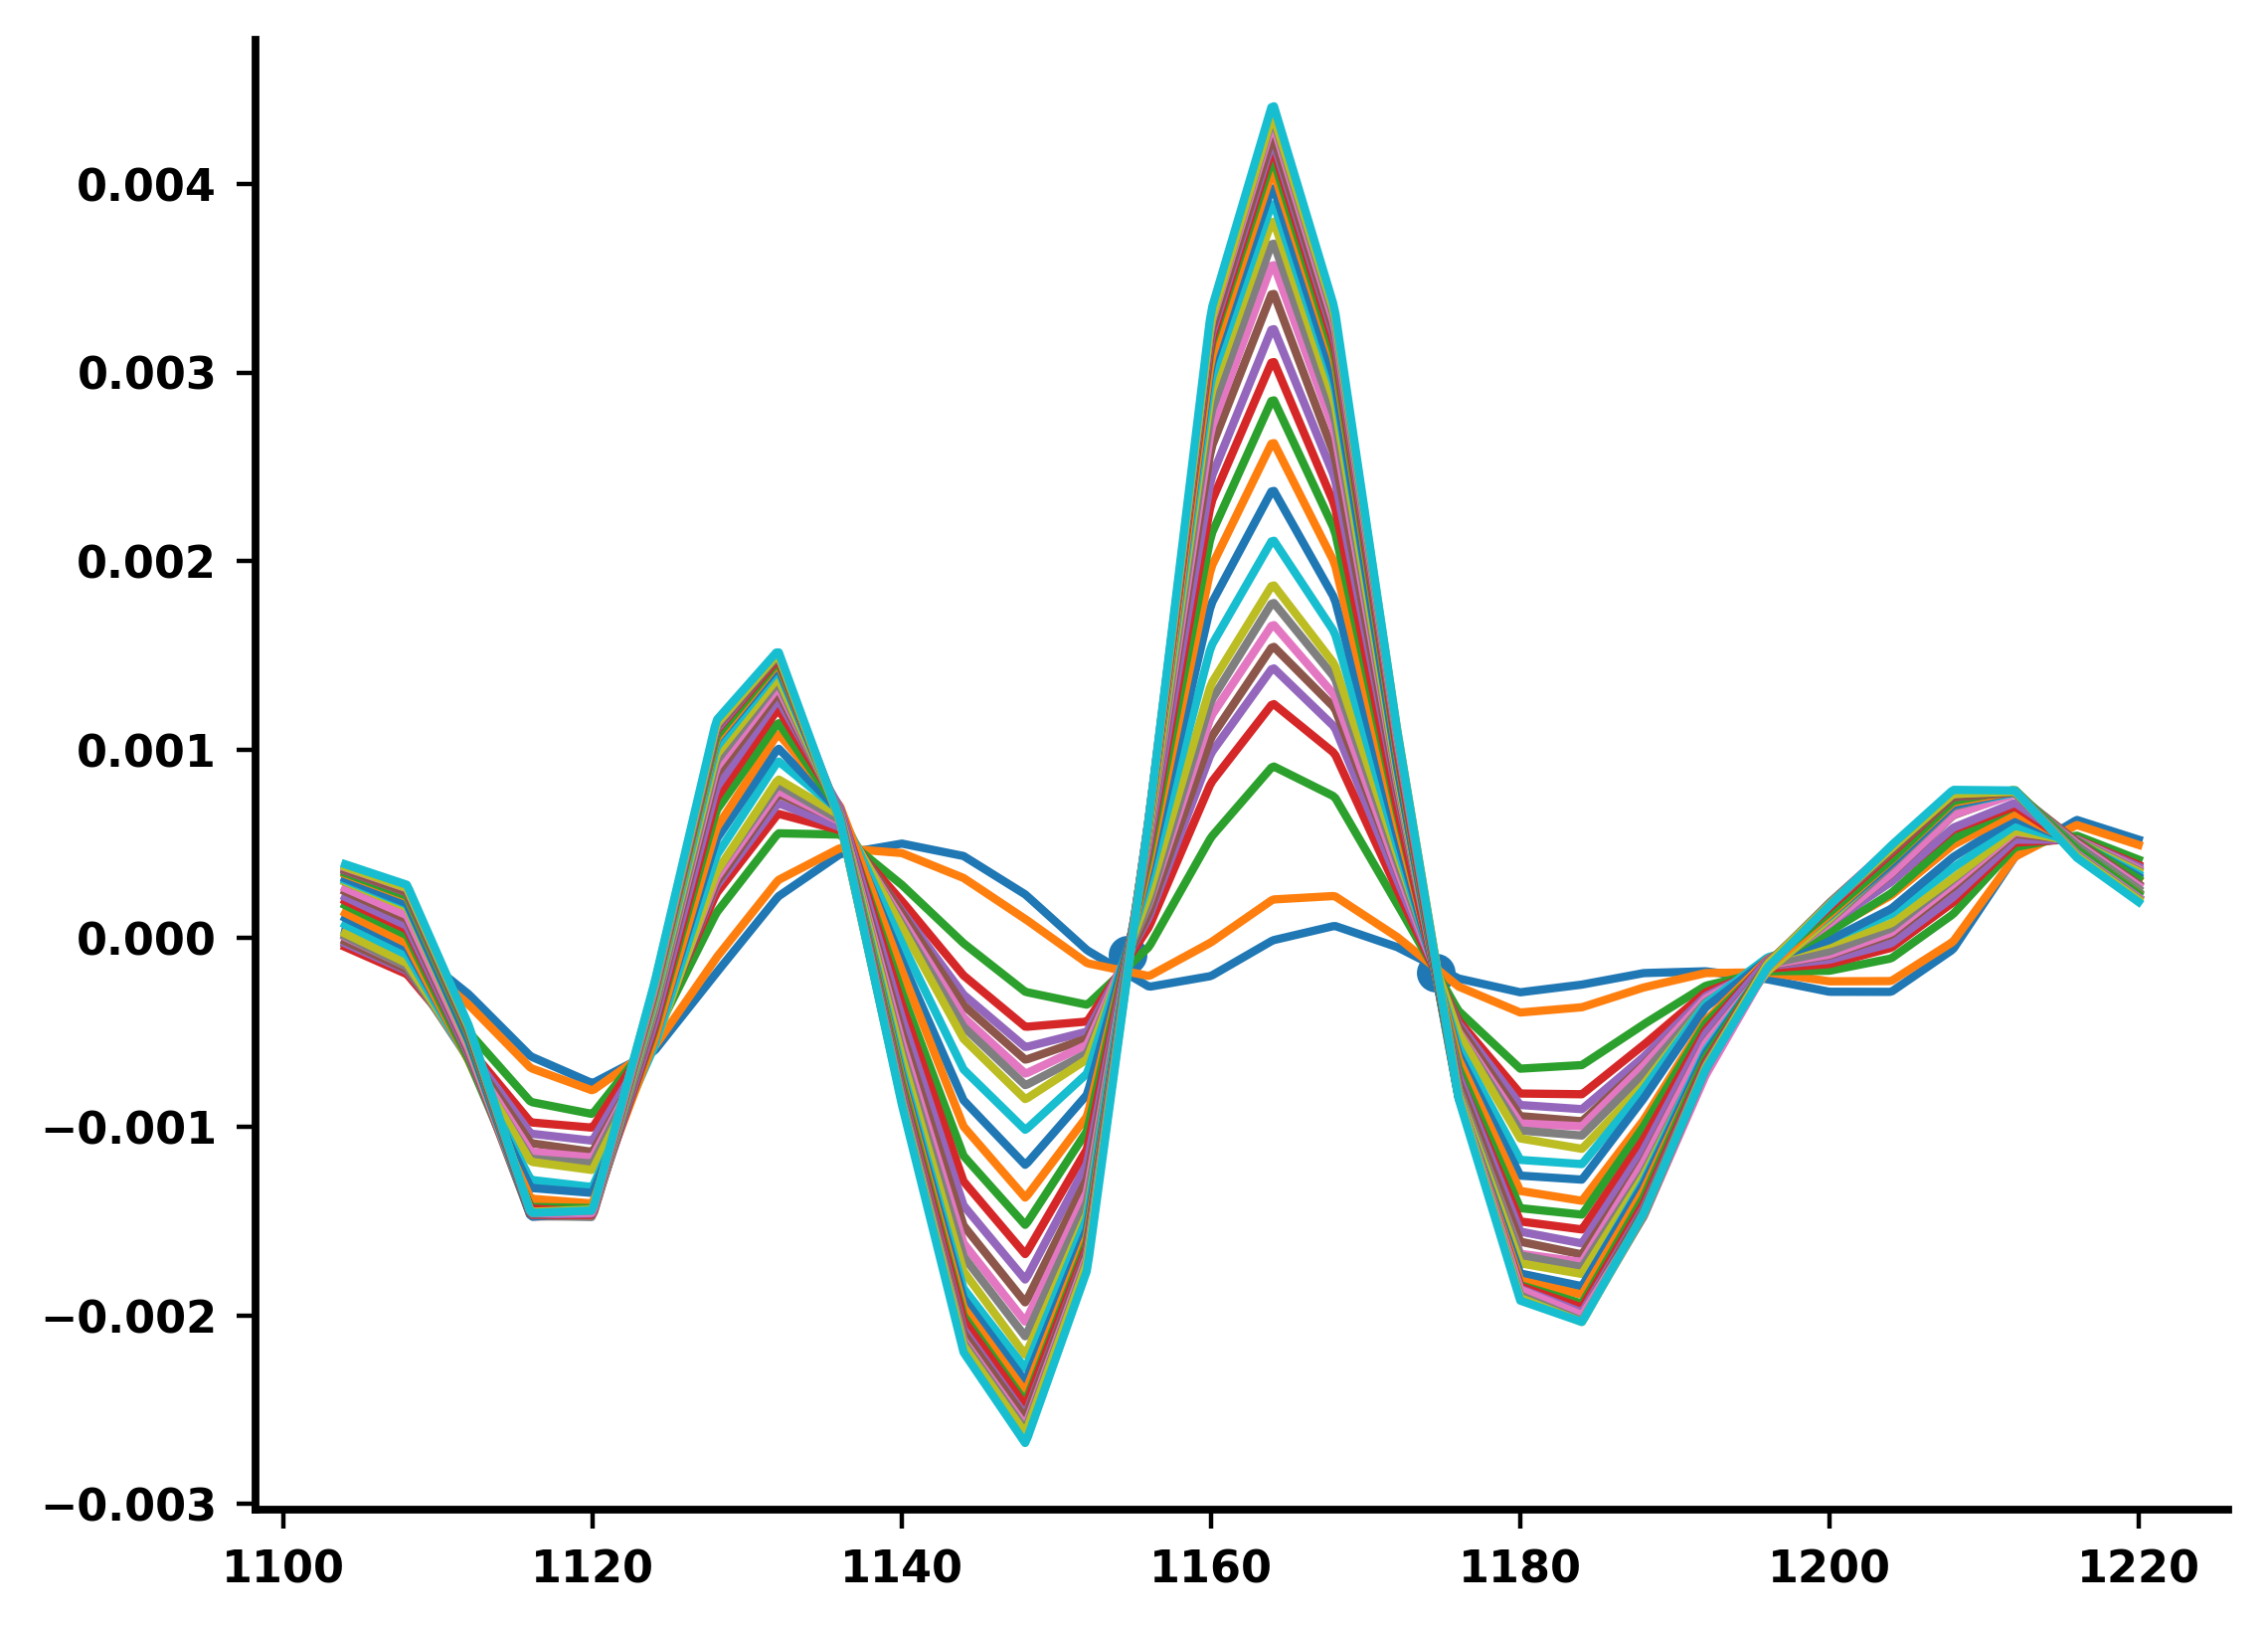

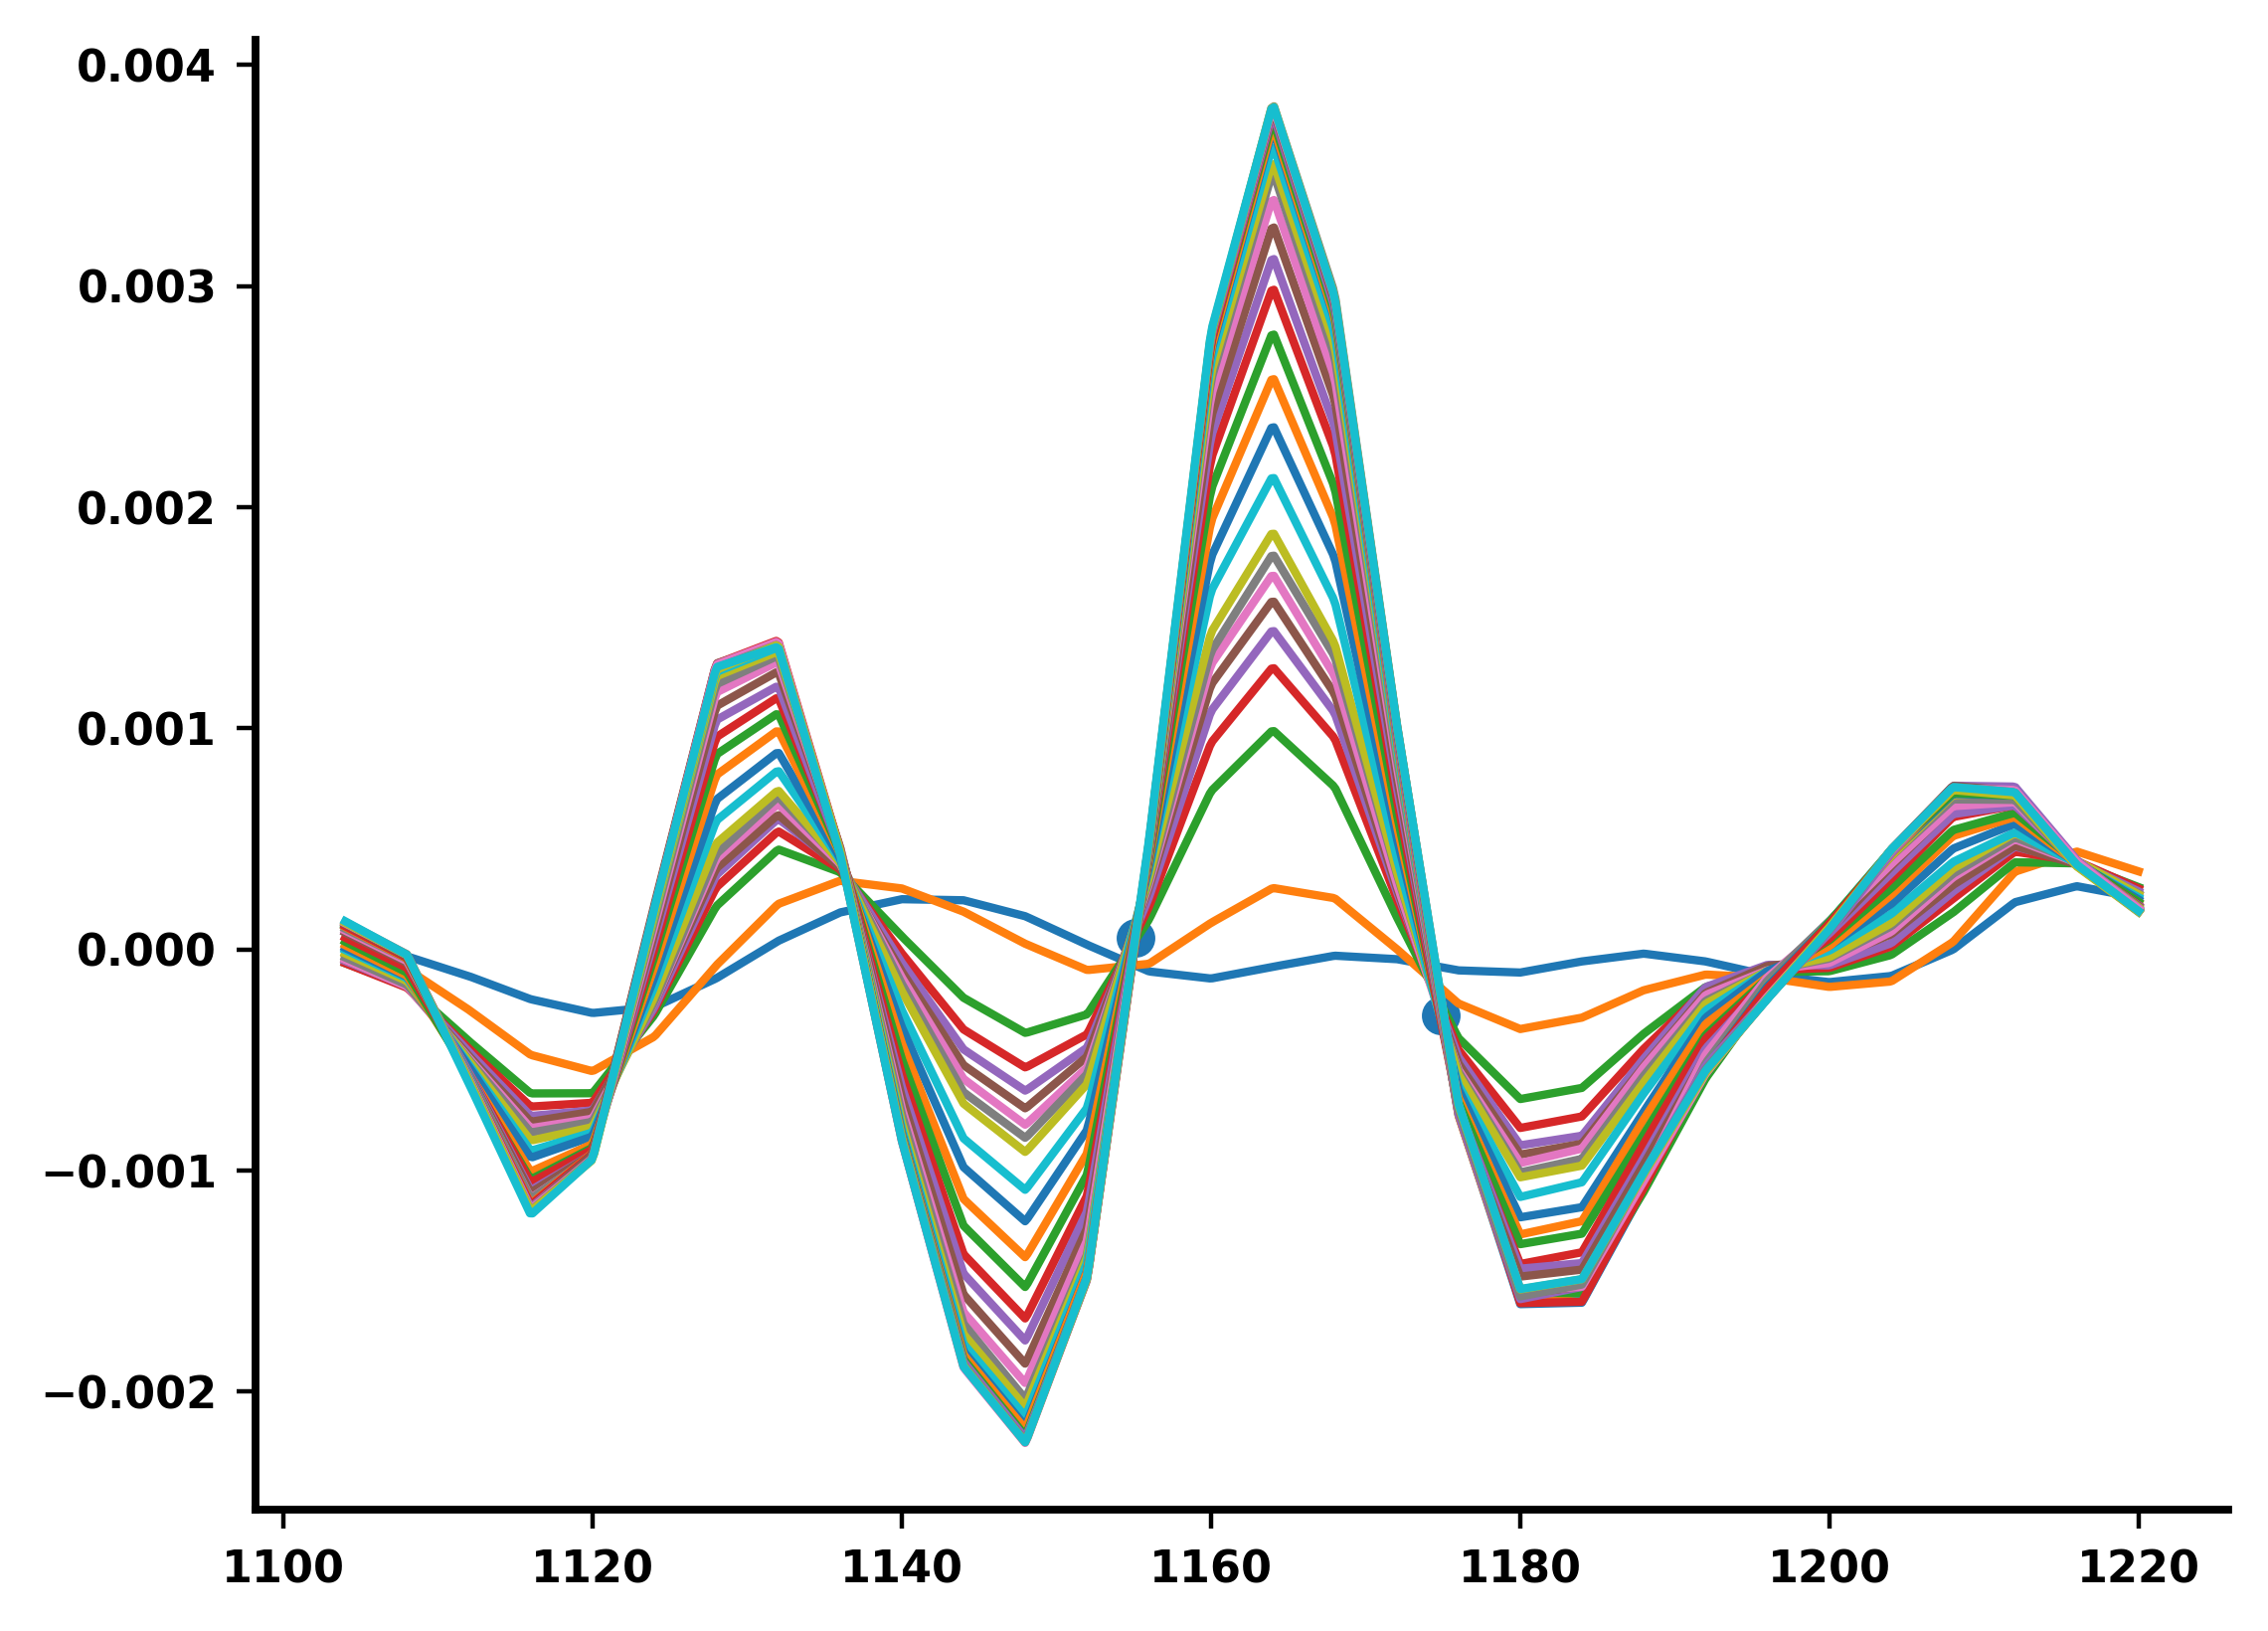

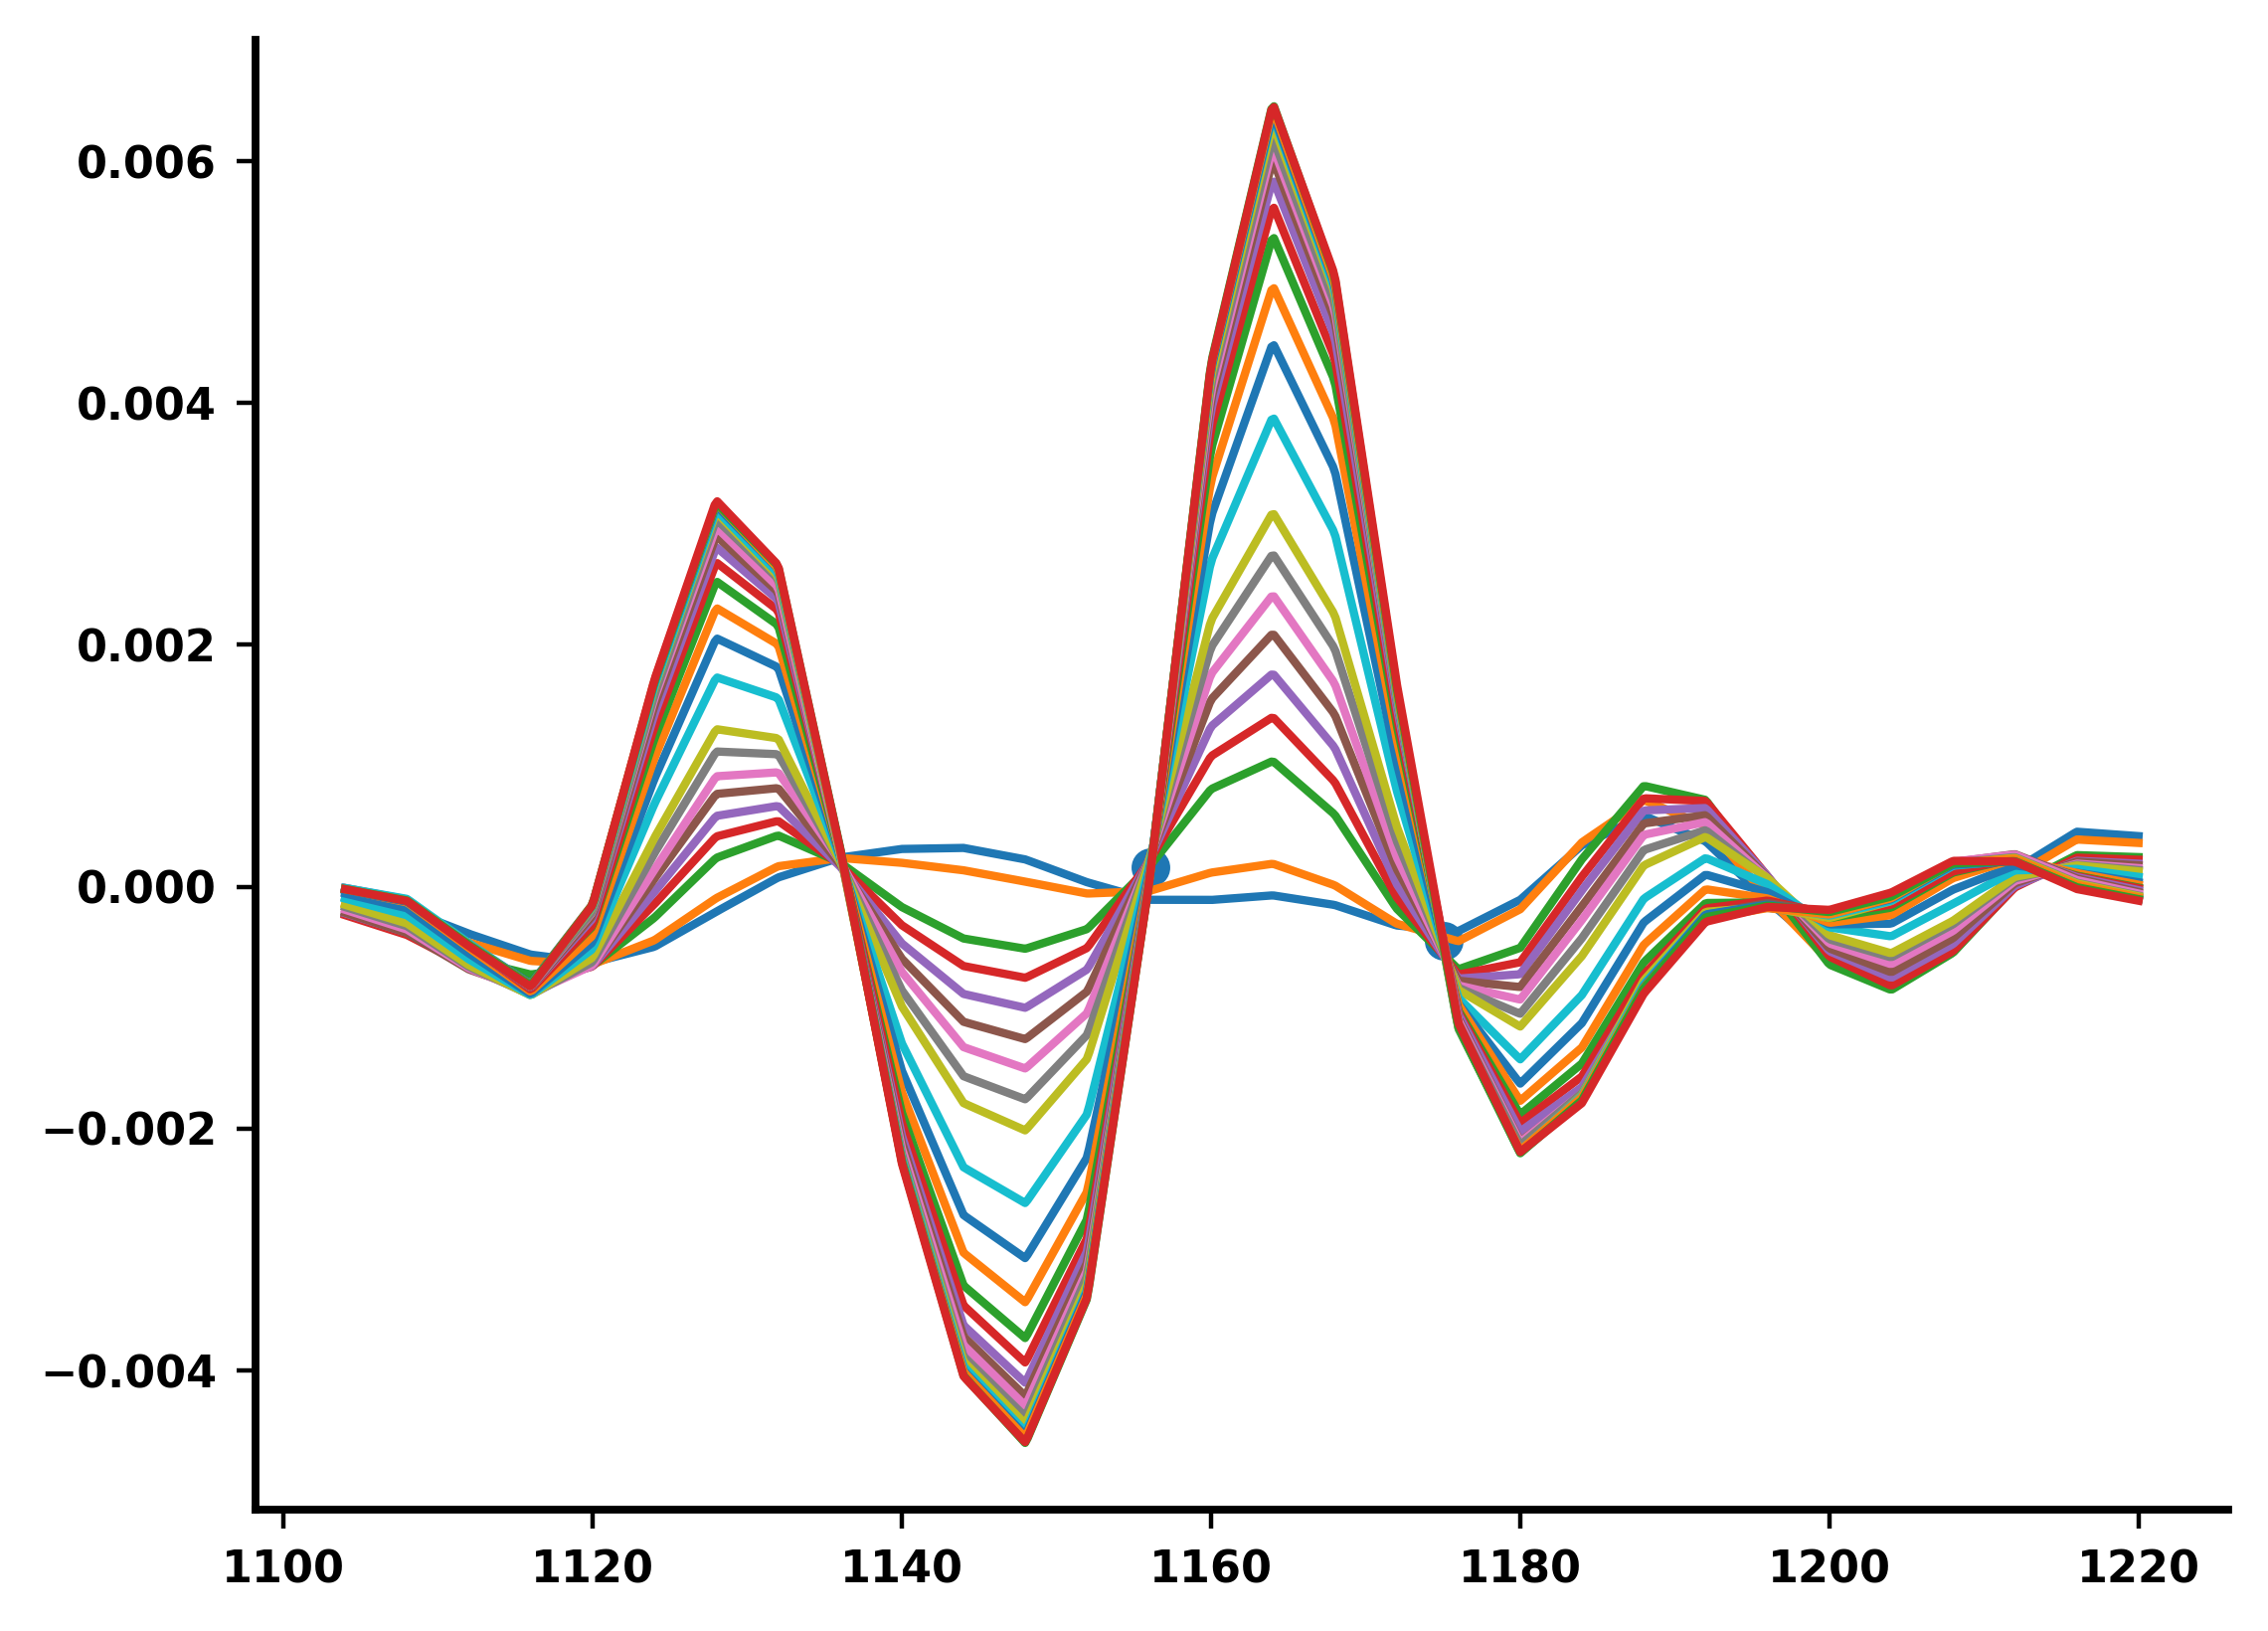

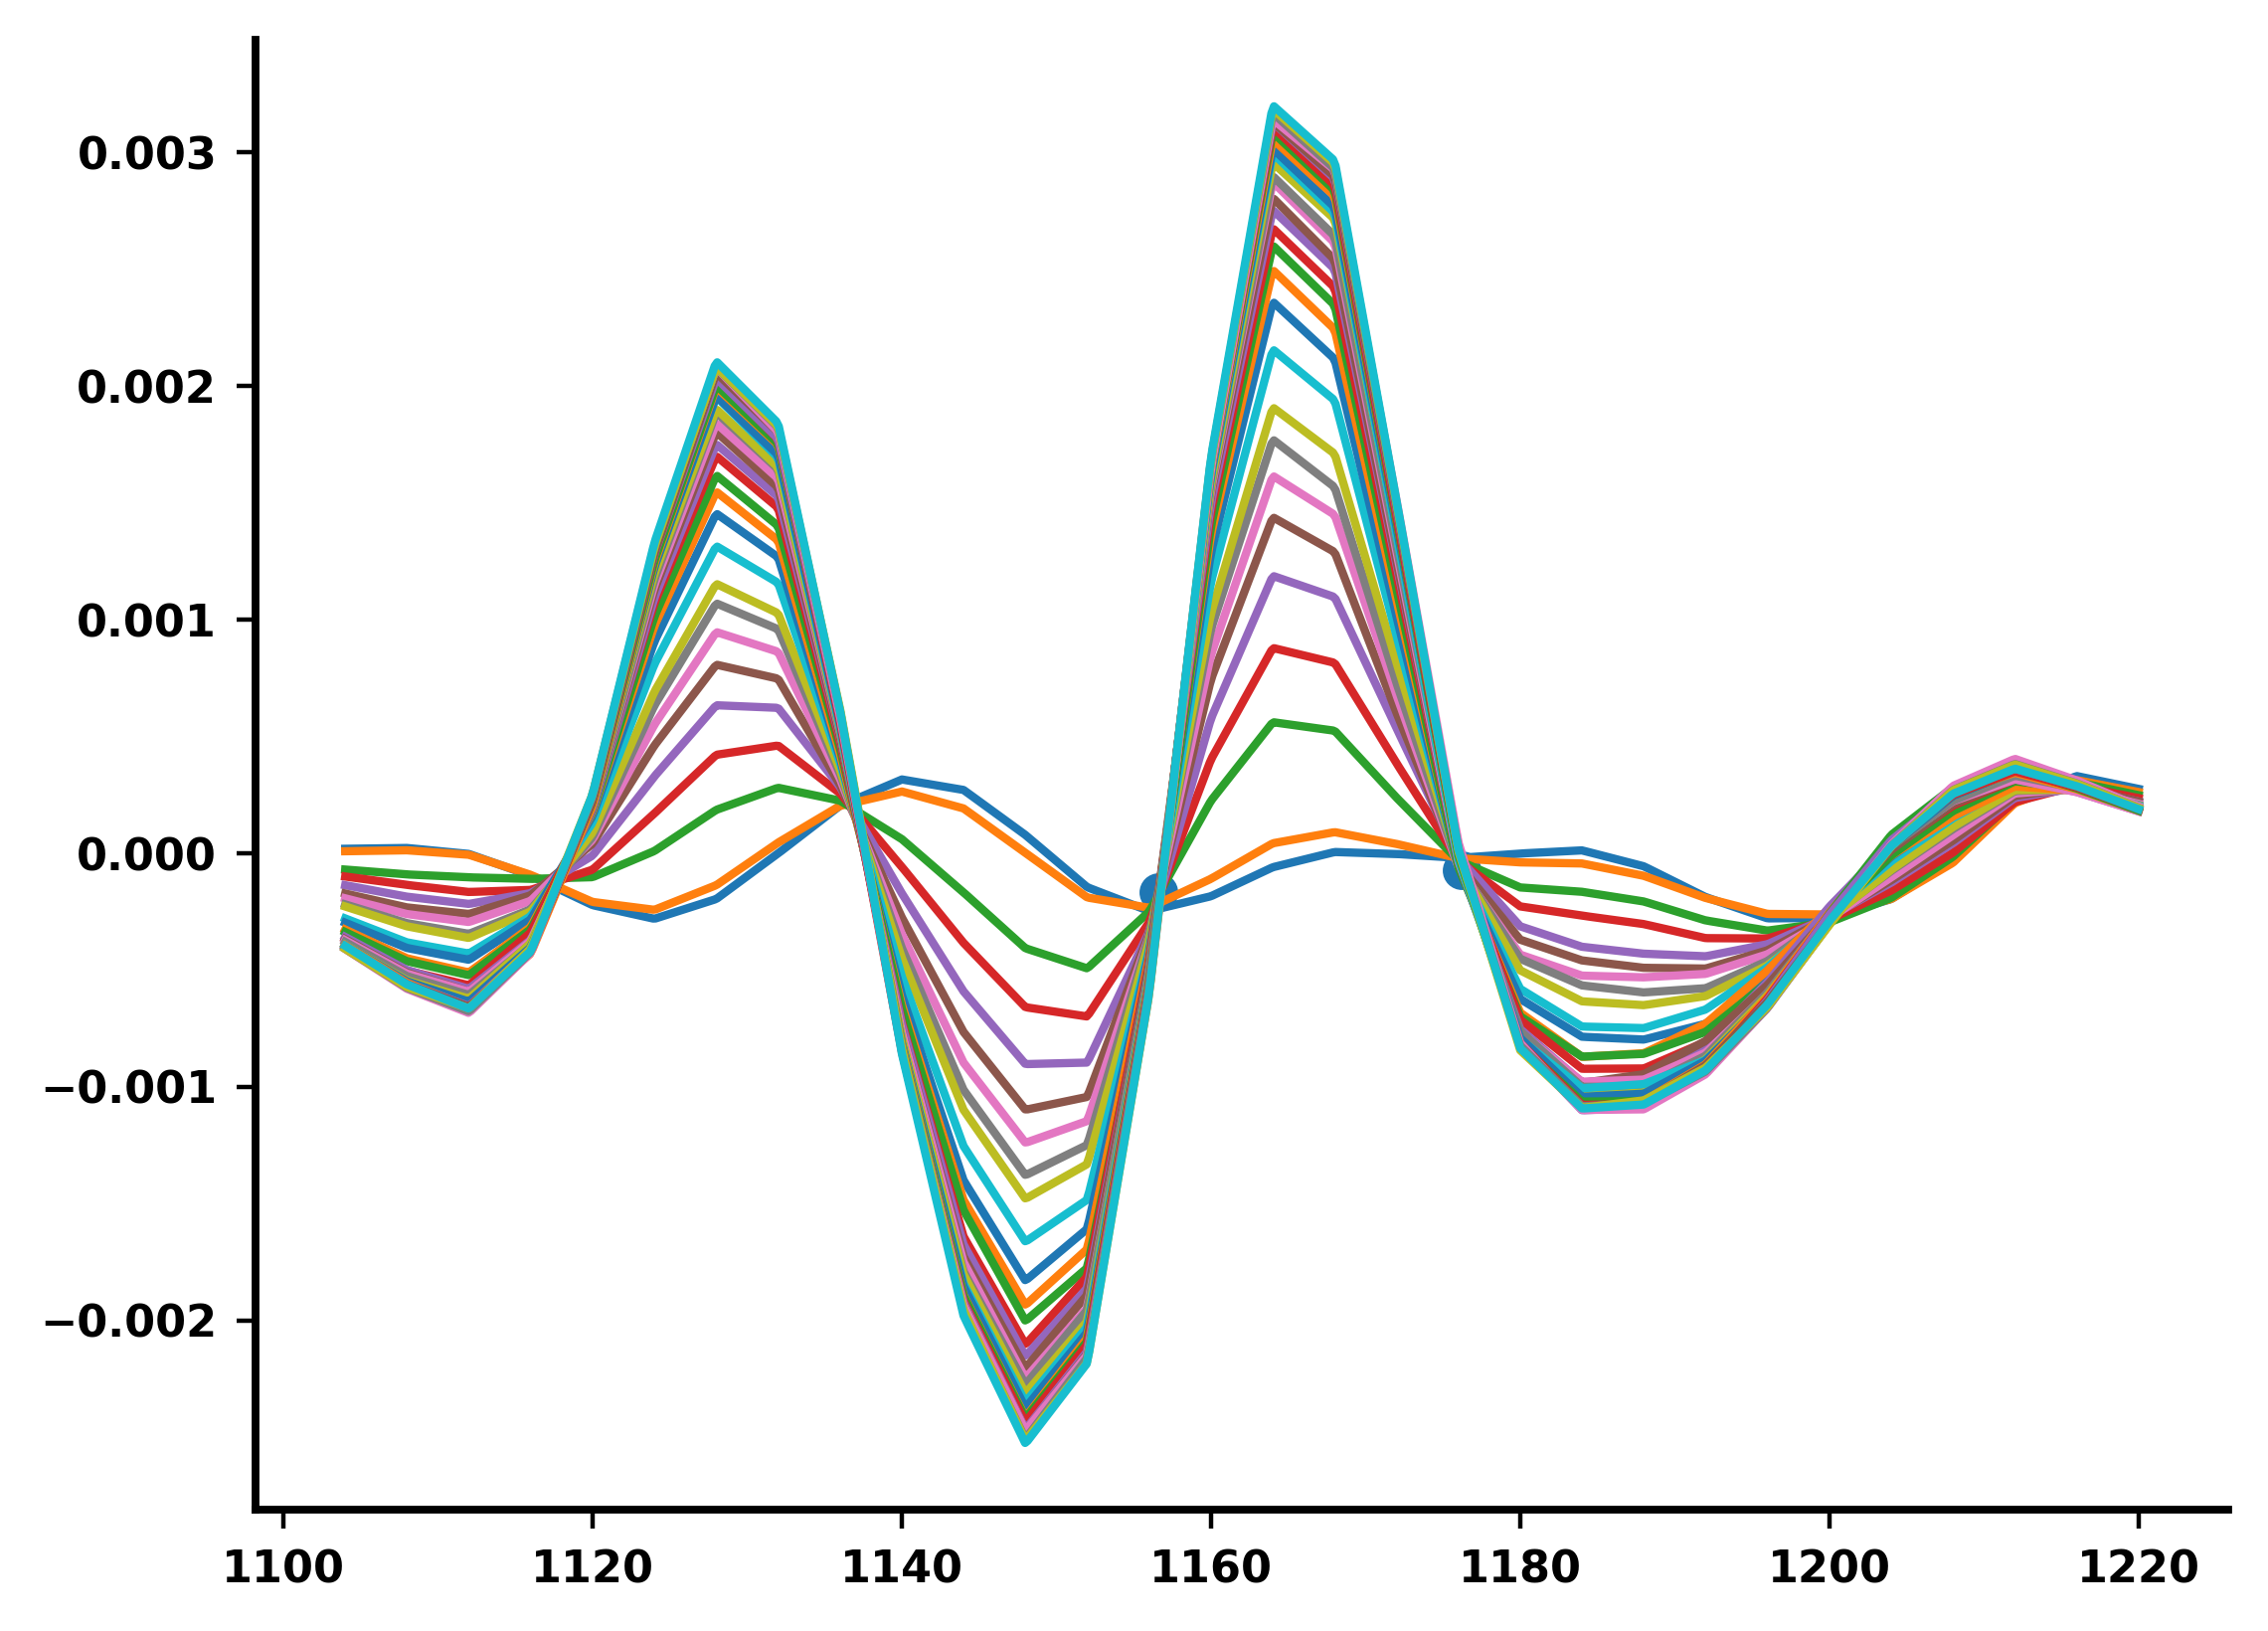

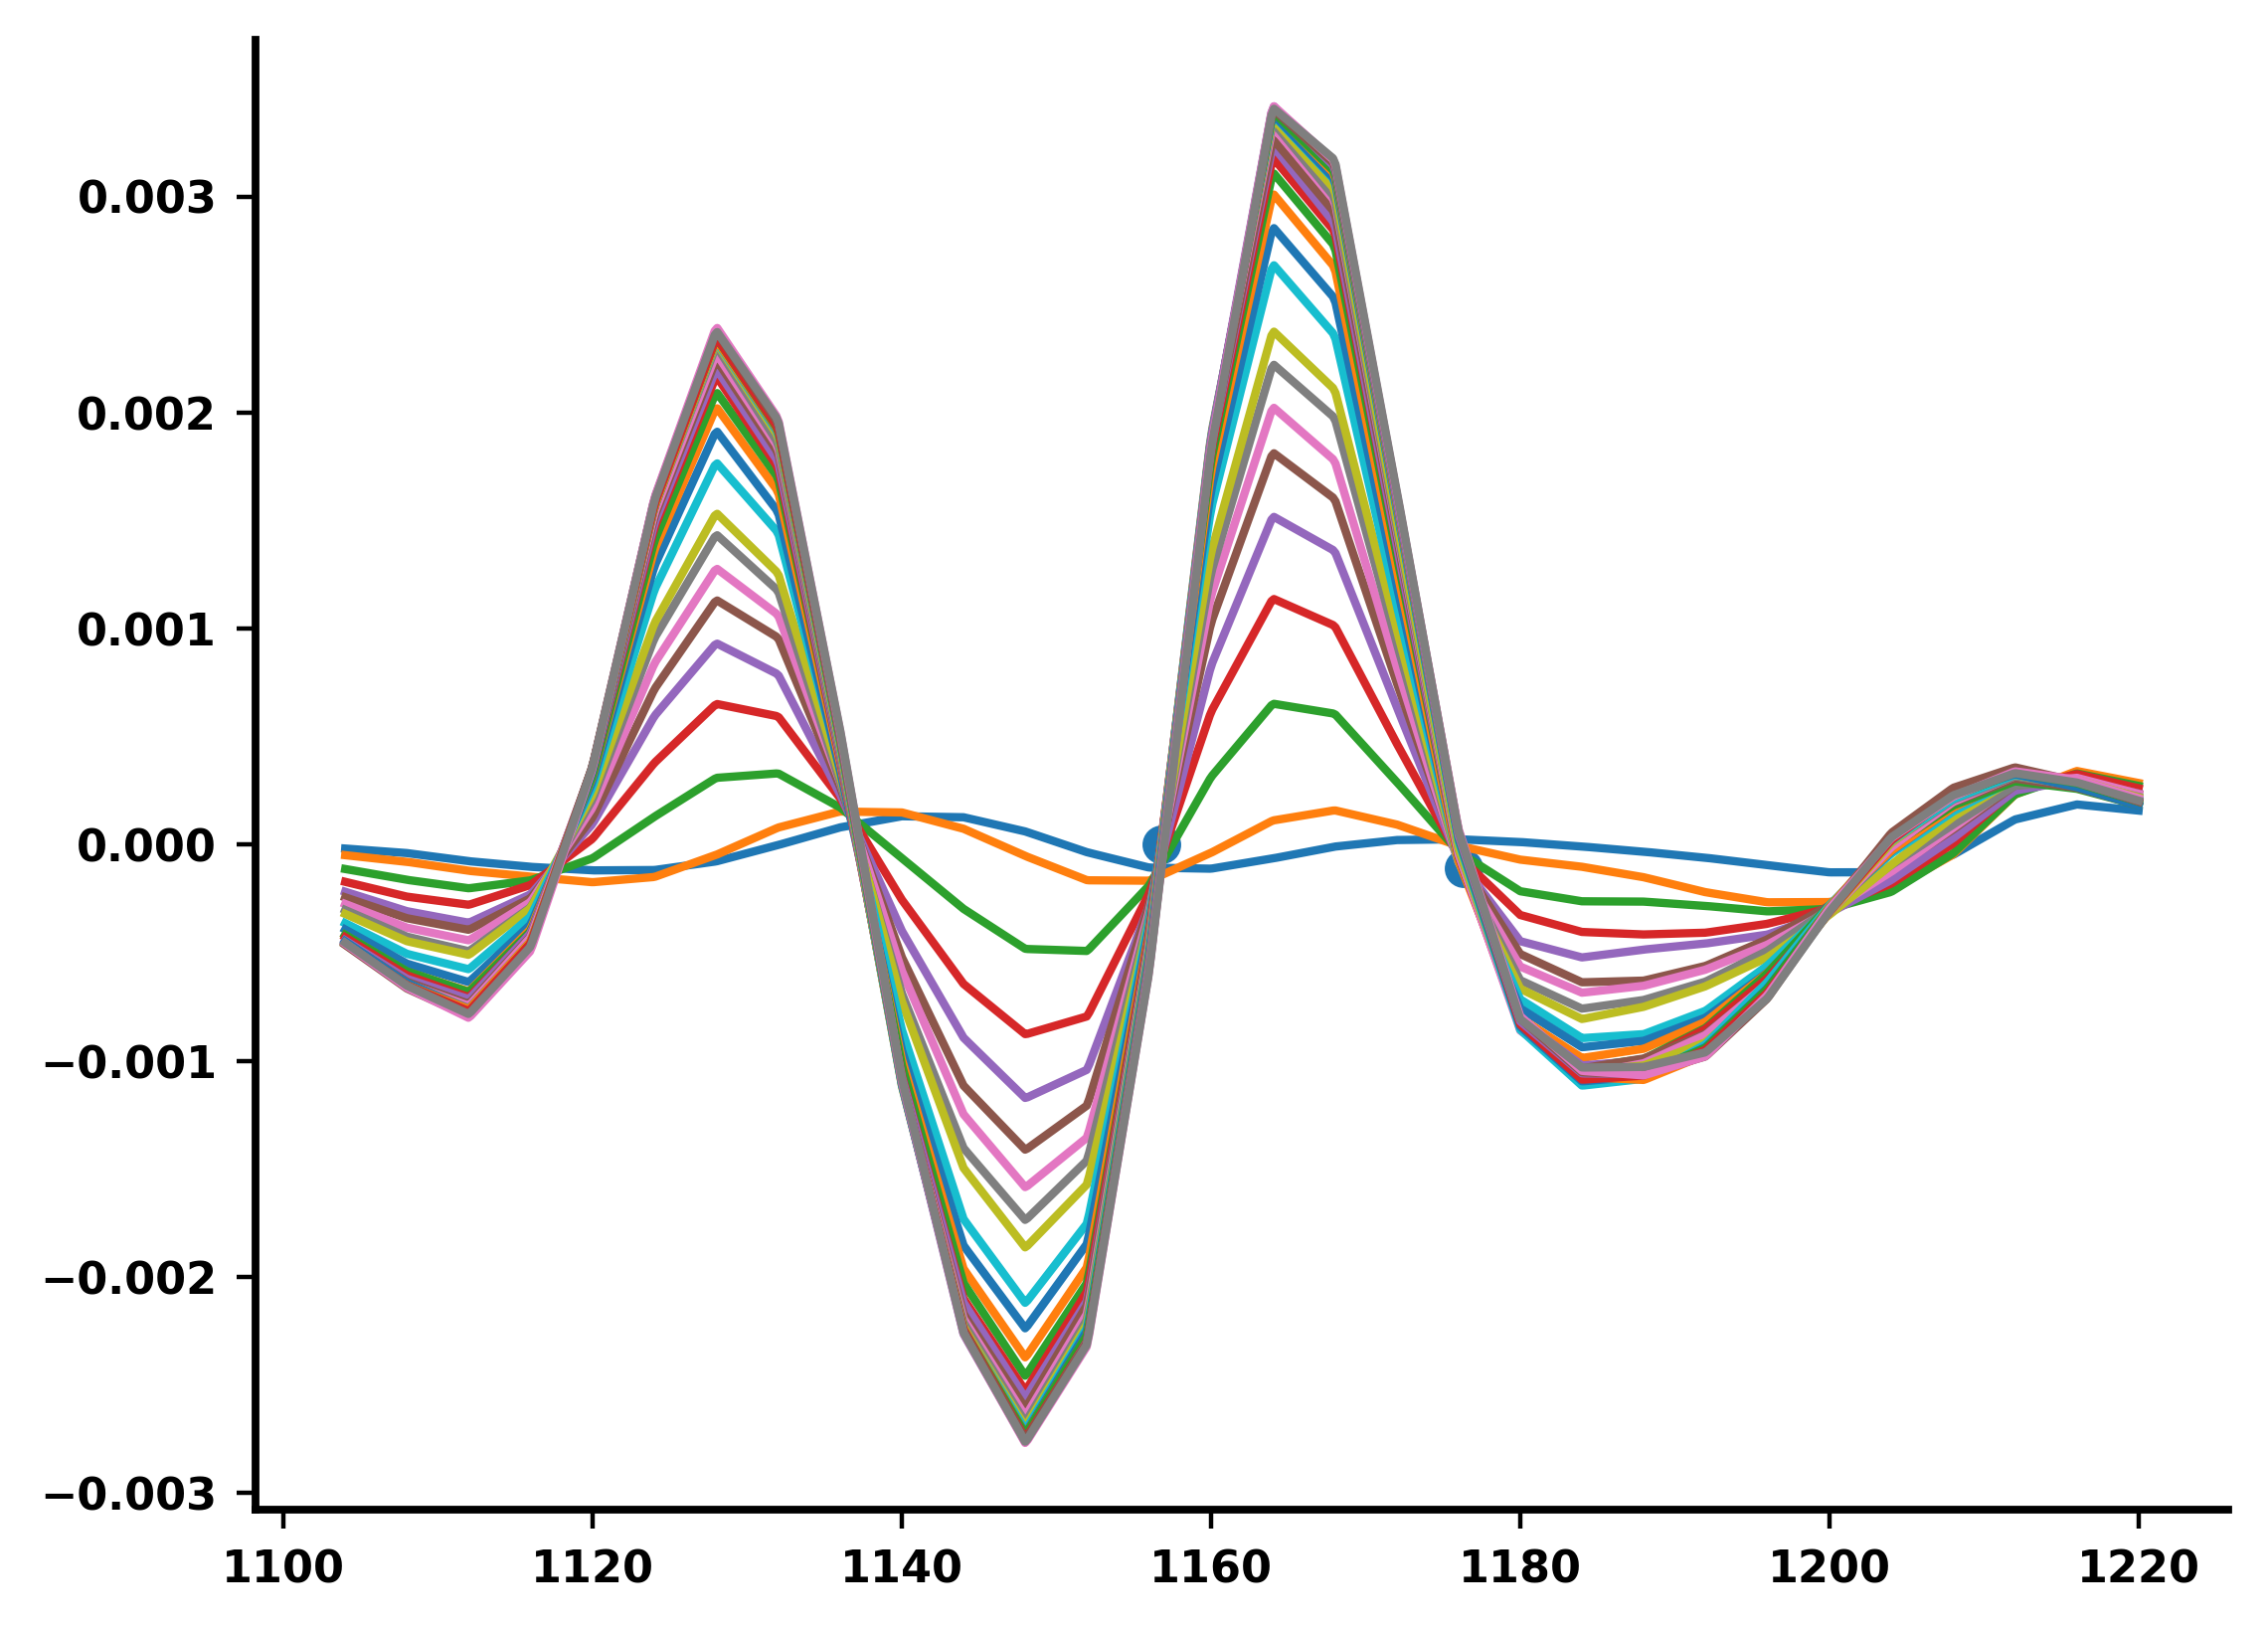

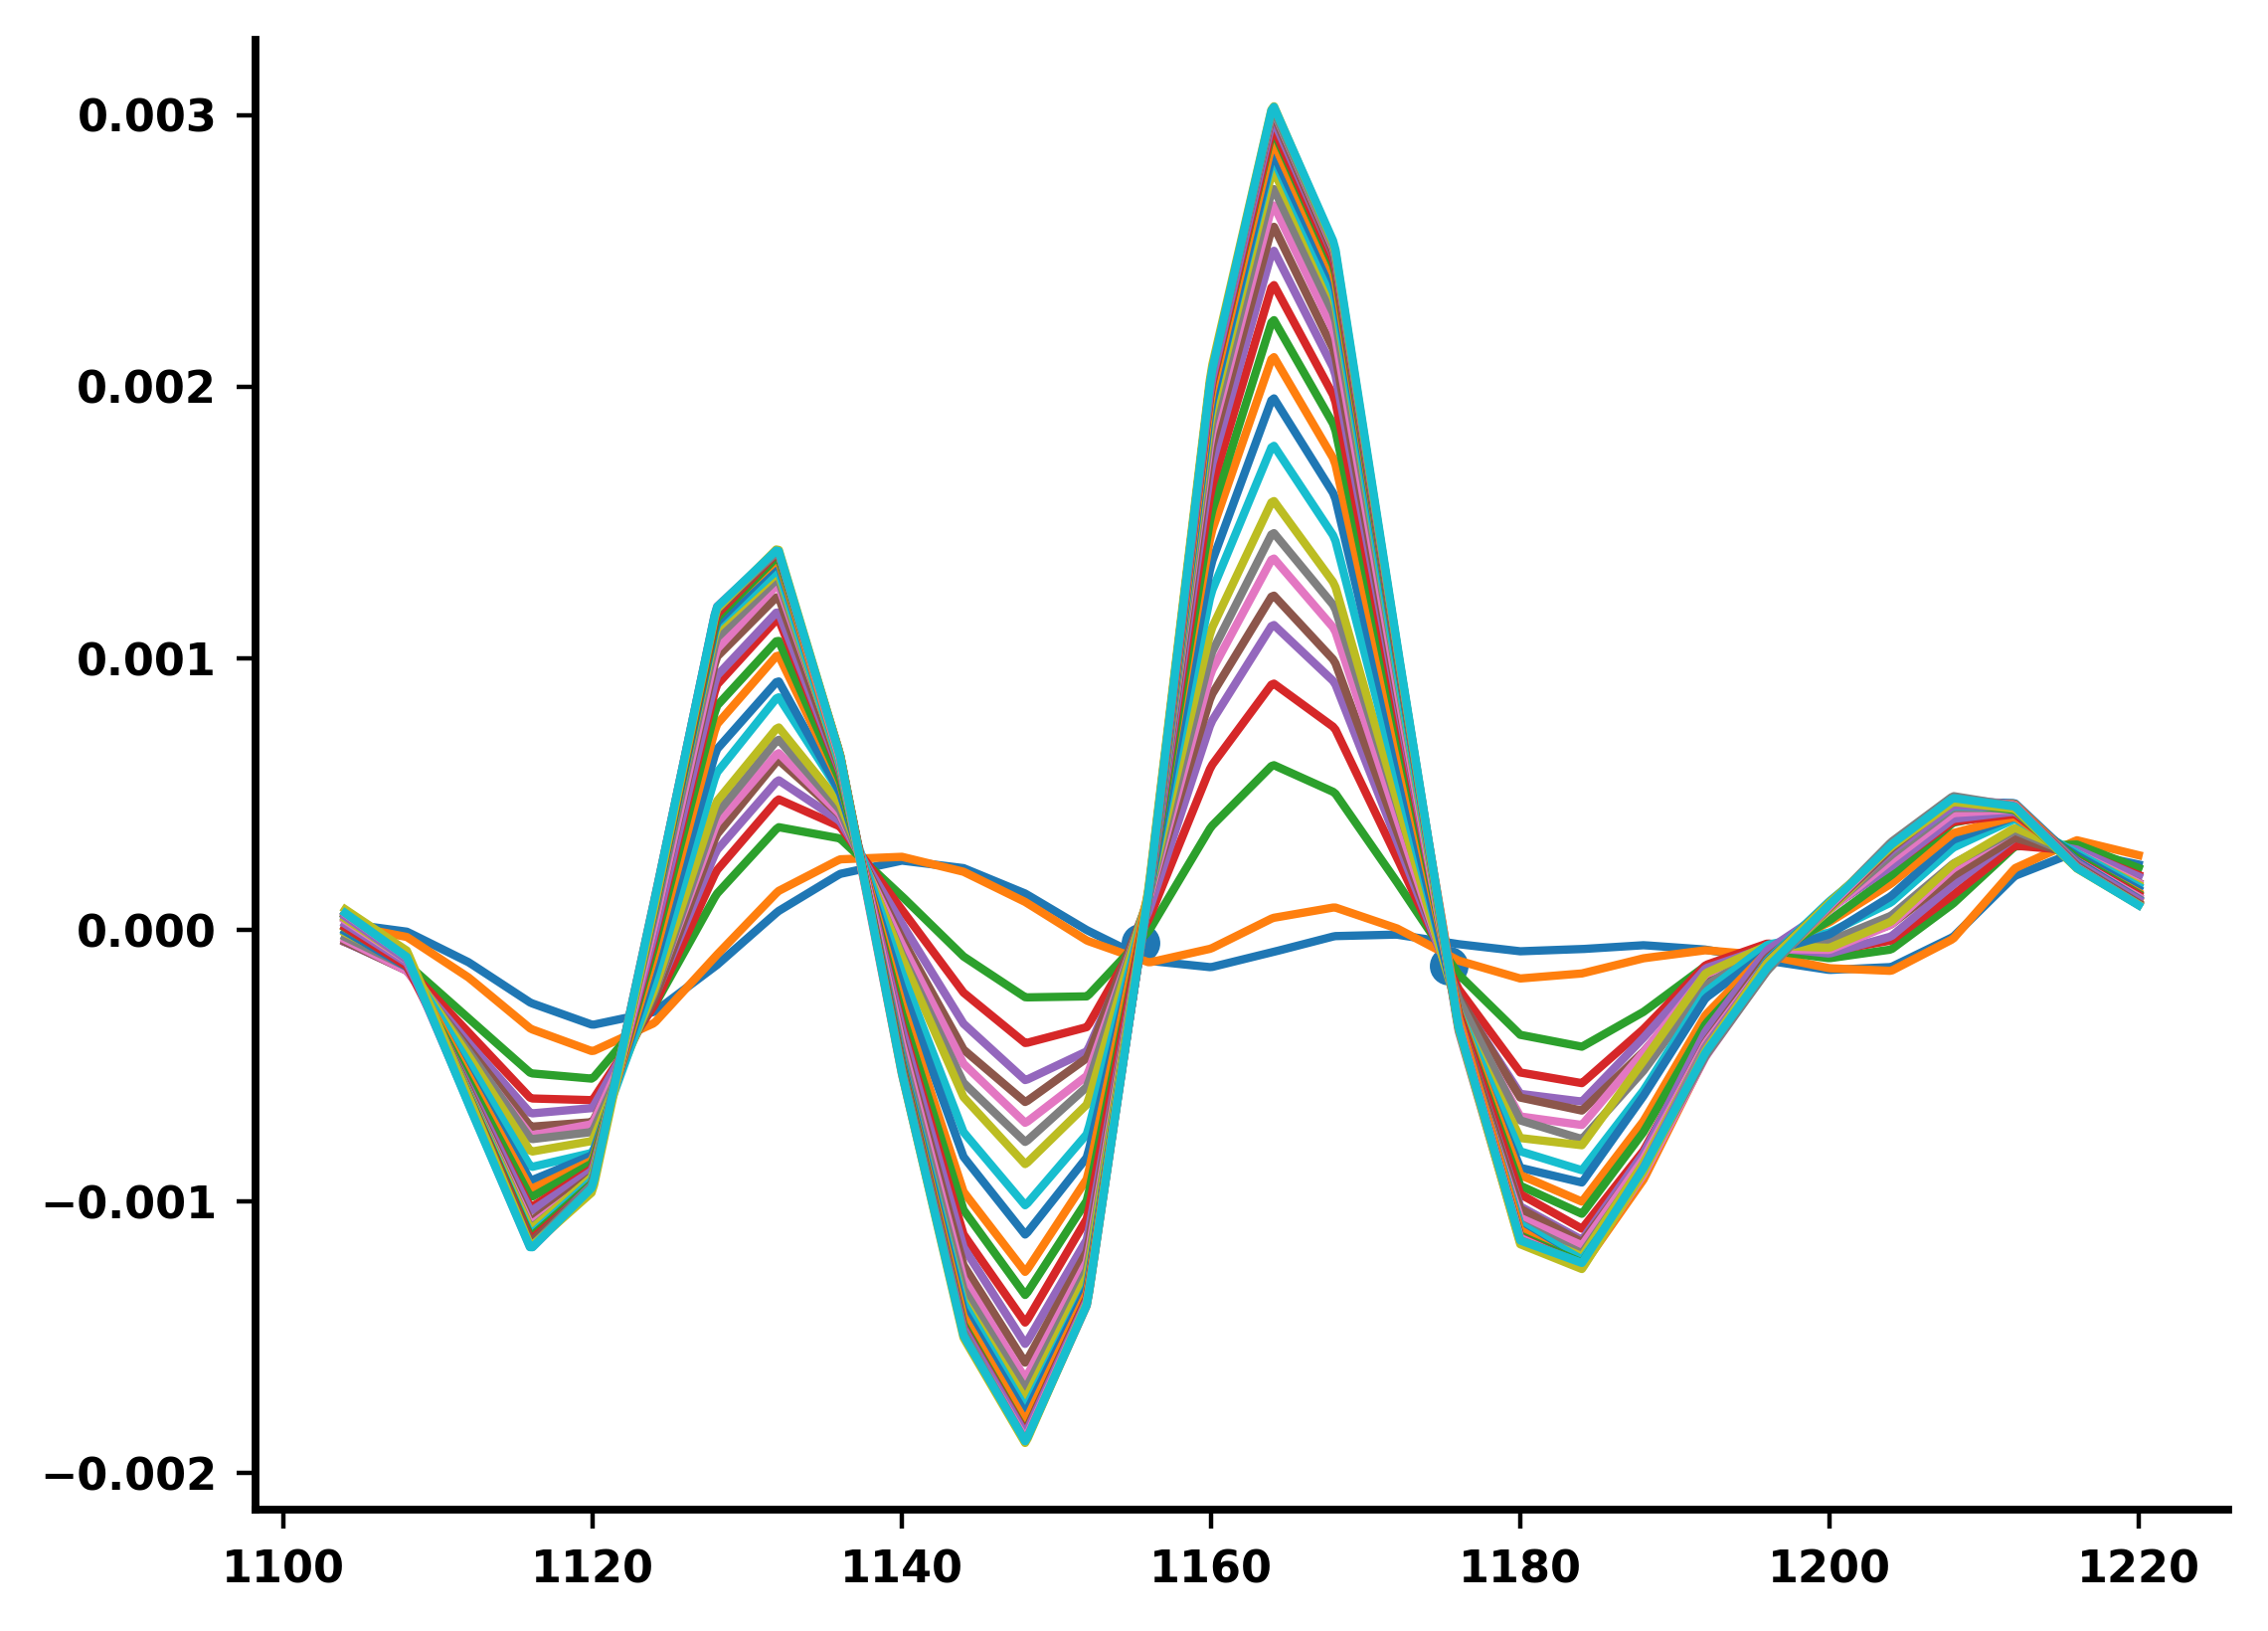

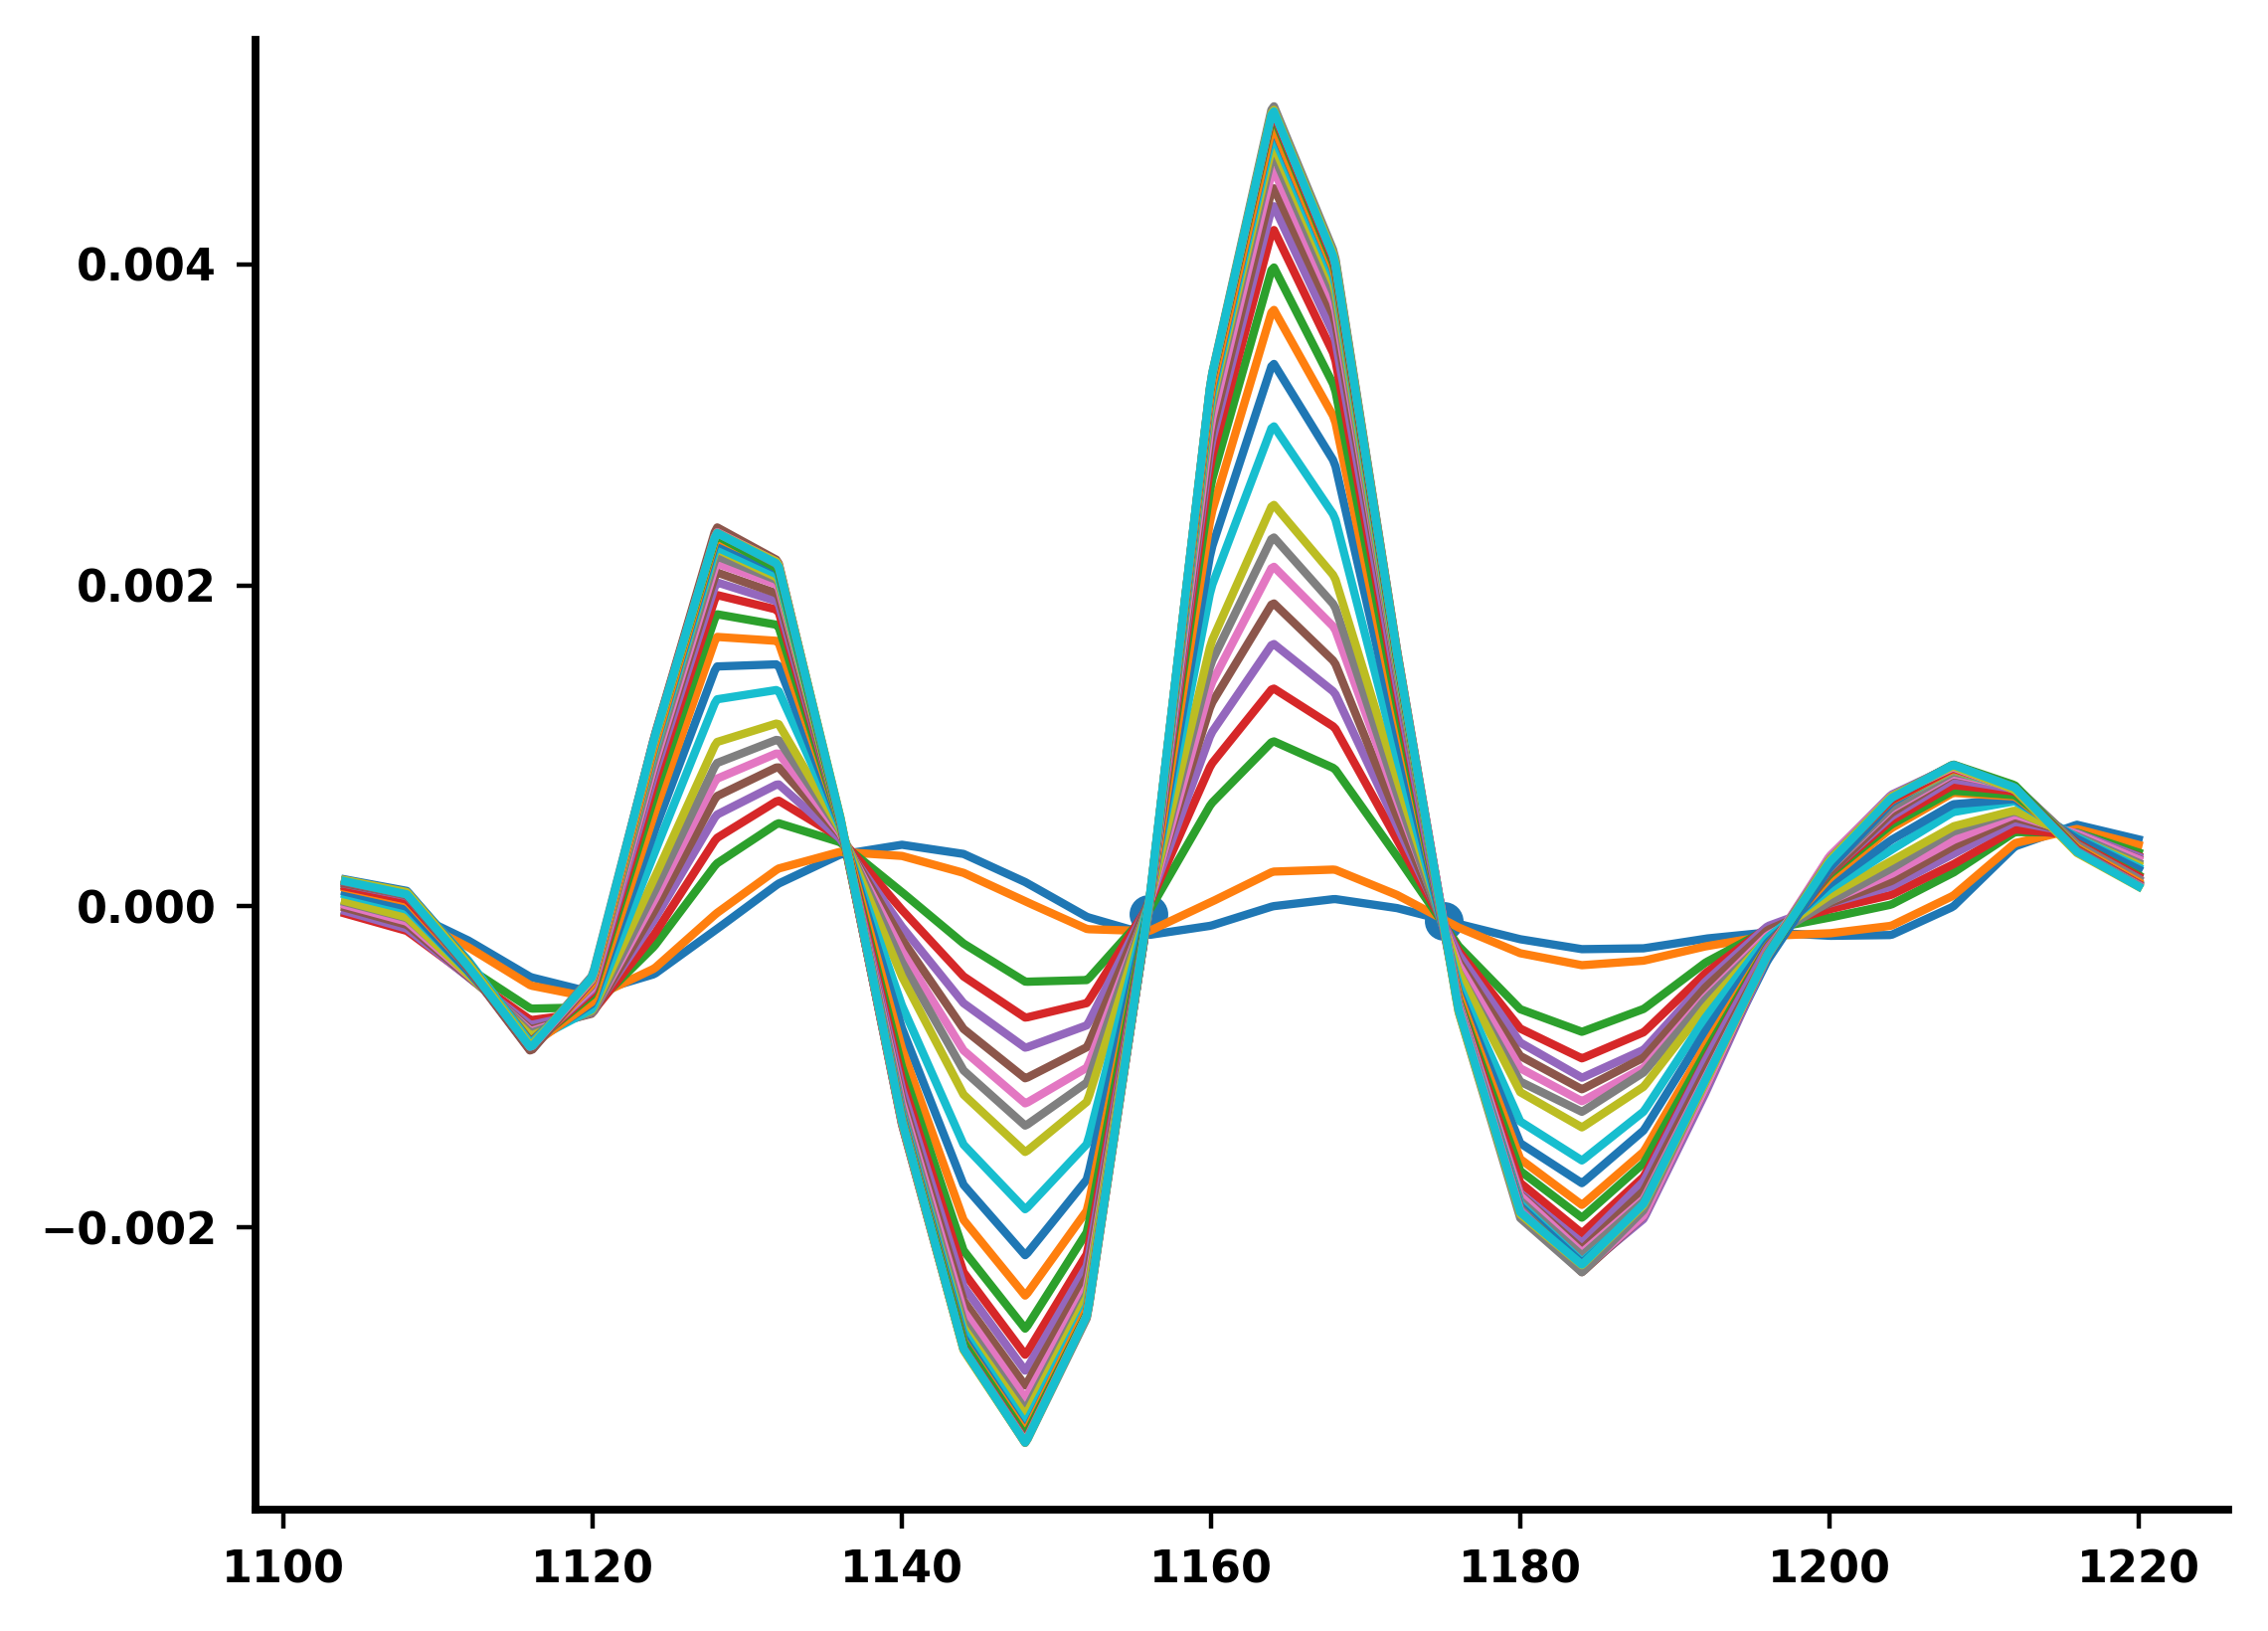

In [11]:
ir_trend_list_match_lc = generateTrends(heightTwoPoints, ir.raw_ir_data_preprocess,
                                        ir.new_dataLList, ir.wave_number_preprocess[::-1], 
                                        1165, diagnostic=15, isosbestic=True, n_sim=700)

all_cal_data = prepDataUnivariateCal(ir_trend_list_match_lc, ir.new_dataLList, ir.lc_data)

# Calibration curve - least squre solution

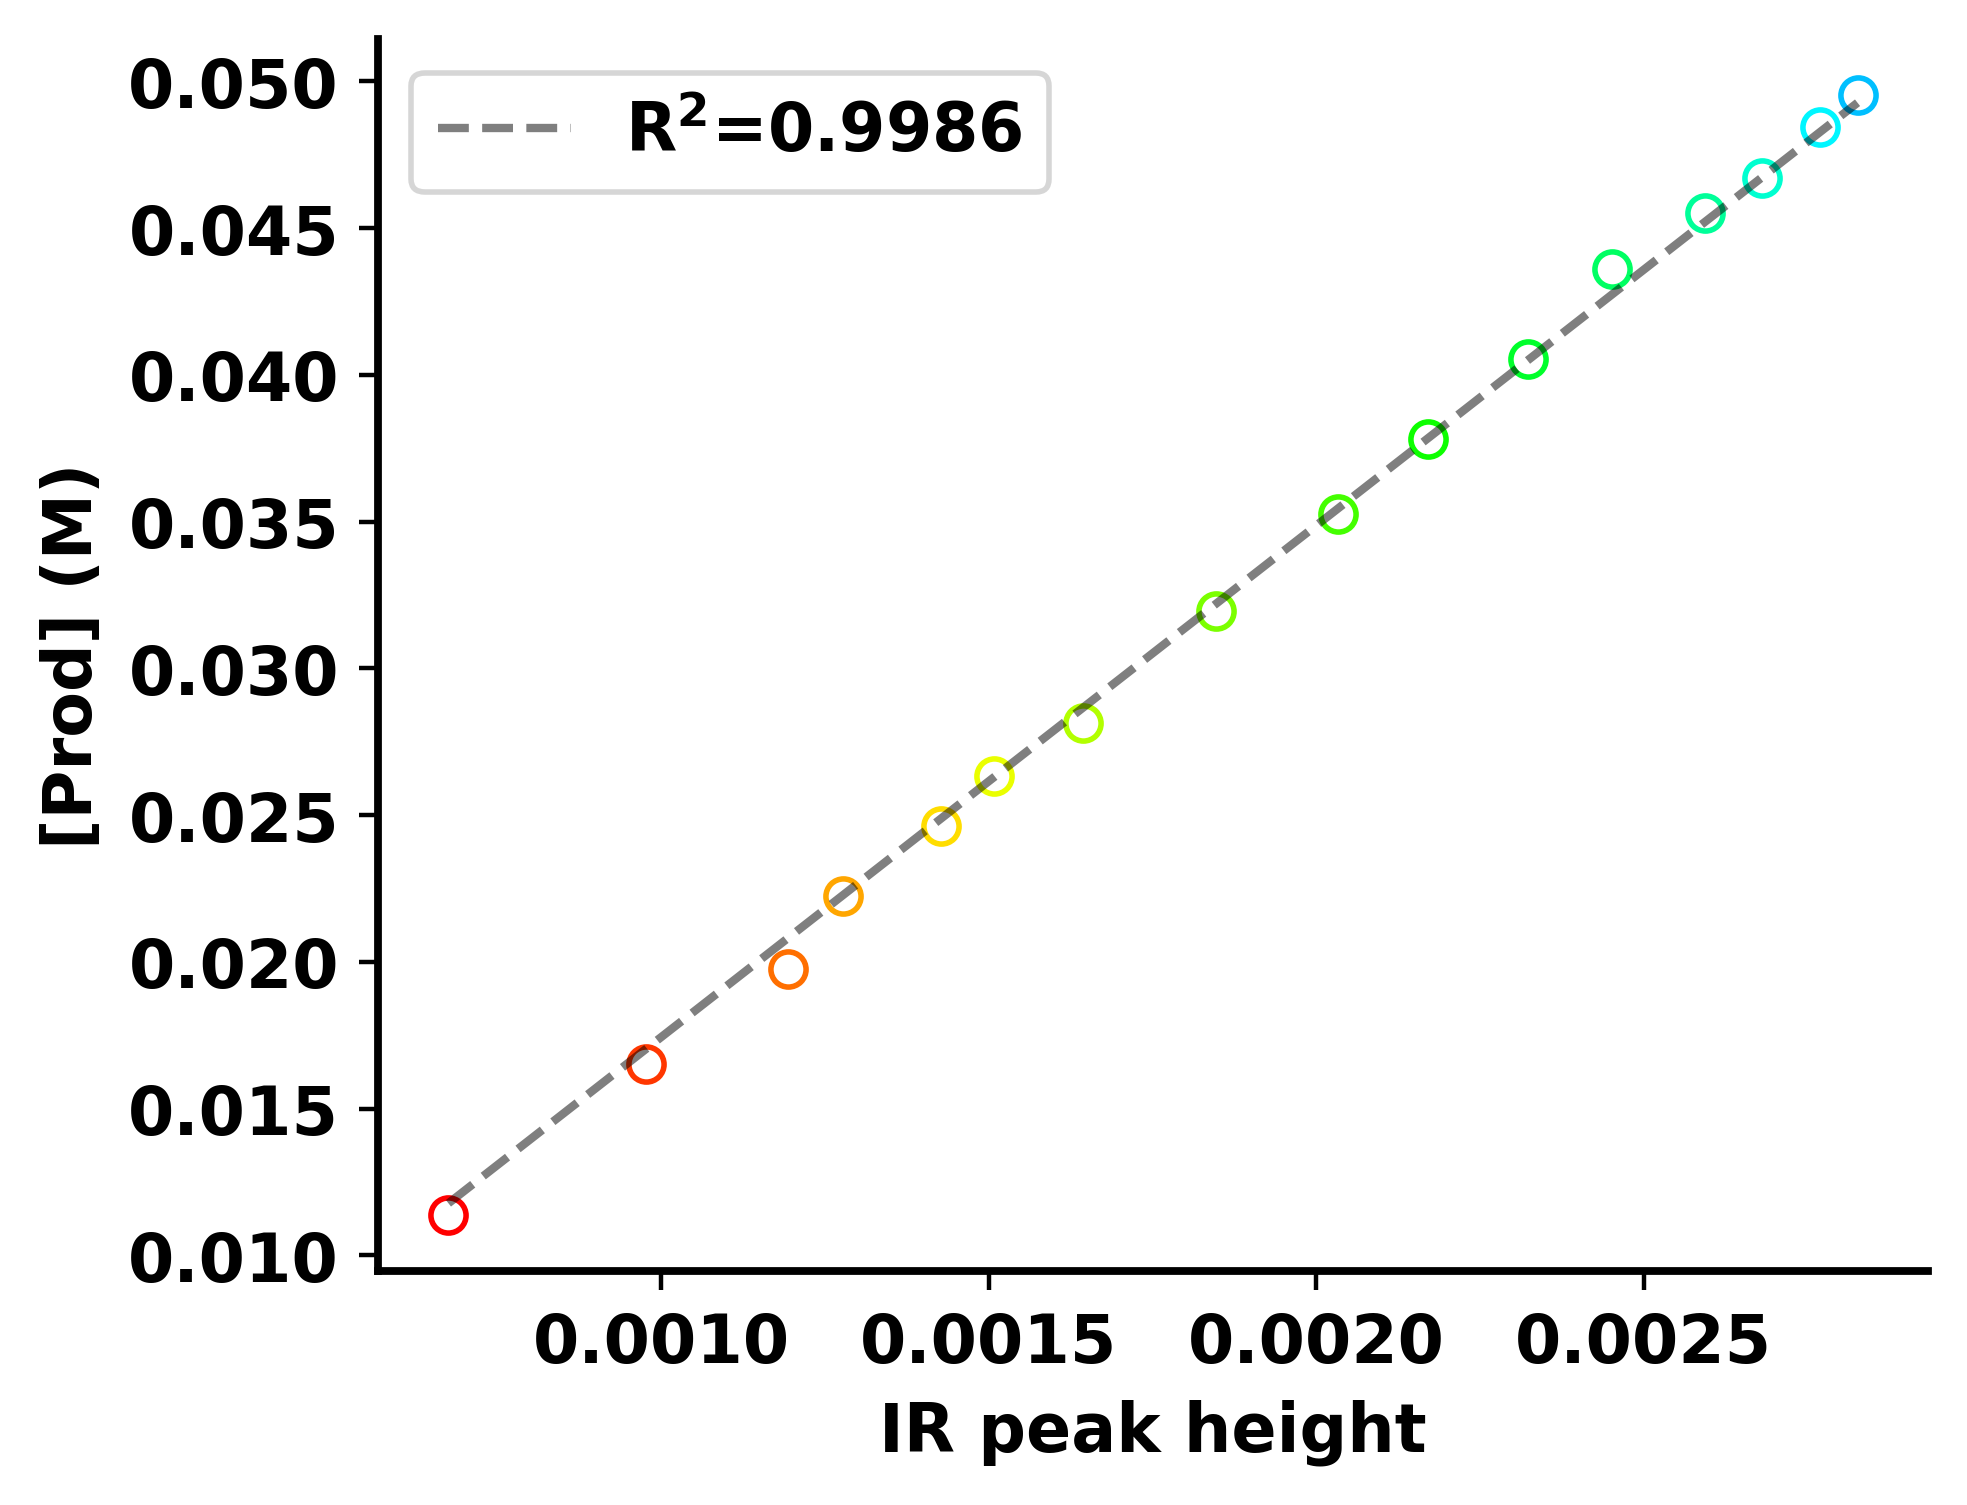

In [12]:
mpl.rcParams['font.size'] = 12
plt.figure(figsize=(5, 4))

ind = 5
startpoint, endpoint = 2, 18
red = Color("red")
colors = list(red.range_to(Color("deepskyblue"), endpoint-startpoint))
x, y = np.array(all_cal_data[ind][1][startpoint:endpoint]).reshape(-1, 1), np.array(all_cal_data[ind][0][startpoint:endpoint])

for i in range(endpoint-startpoint): 

    plt.scatter(x[i], y[i], facecolor='w', edgecolor=colors[i].get_rgb(), s=40)

plt.xlabel('IR peak height')
plt.ylabel('[Prod] (M)')

rgr = LinearRegression(fit_intercept=False)
rgr.fit(x, y)
plt.plot(x, rgr.predict(x), ls='--', c='k', label=fr'R$^2$={str(rgr.score(x, y))[:6]}', alpha=0.5)
plt.legend()

# Generating calibration curves using Bayesian approaches

In [ ]:
train_ind = 5

In [13]:
# baseline model
with Model() as model: 

    sigma = HalfCauchy("sigma",beta=1)
    slope_1 = Normal("slope_1", 20, sigma=1)
    x1, y1 = all_cal_data[train_ind][1][startpoint:endpoint], all_cal_data[train_ind][0][startpoint:endpoint]

    # for 1-d data, need to make sure that obs is flattened, or otherwise the inference will go bad
    likelihood = Normal('y1', mu=slope_1*x1, sigma=sigma, observed=y1.flatten())
        
    idata_0 = sample(chains=4, cores=4)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, slope_1]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 15 seconds.


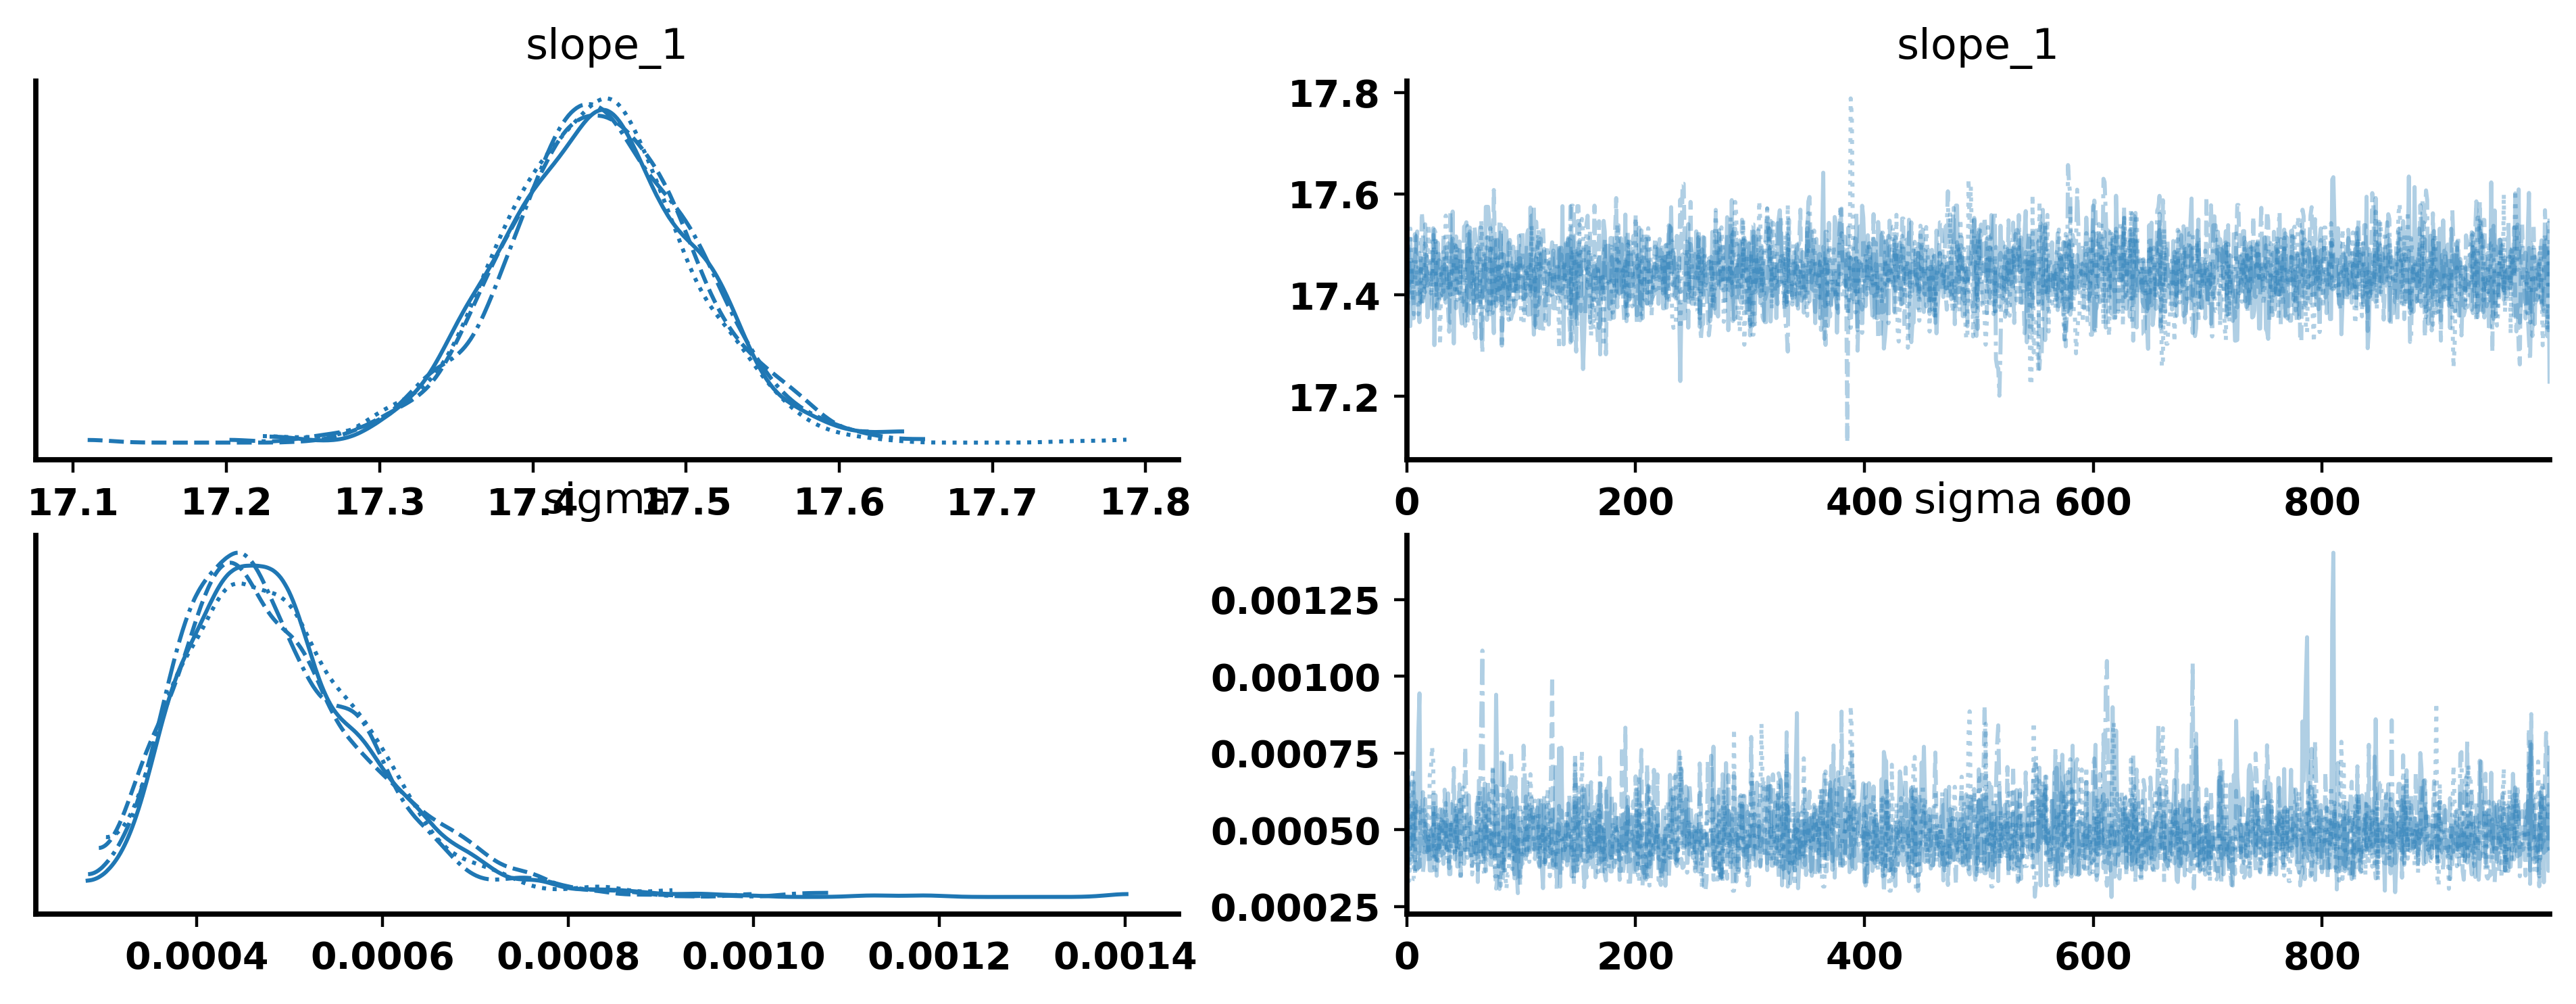

In [14]:
az.plot_trace(idata_0);

In [16]:
# use the estimated posterior for slope and sigma to predict using the entire IR data set
test_ind = 5
test_ir_trend = np.array(generateTrends(heightTwoPoints, ir.real_raw, ir.dataLList,
                                        ir.wave_number_preprocess[::-1], 1165, diagnostic=False, isosbestic=True)[test_ind][ir.ir_index_match_lc[test_ind][0]:ir.ir_index_match_lc[test_ind][1]])


In [ ]:
with Model() as test_model: 

    sigma = HalfCauchy("sigma", beta=1)
    slope_1 = Normal("slope_1", 2, sigma=5)
    x1, y1 = test_ir_trend, np.zeros(test_ir_trend.shape)

    # for 1-d data, need to make sure that obs is flattened, or otherwise the inference will go bad
    likelihood = Normal('y_test', mu=slope_1*x1, sigma=sigma, observed=y1.flatten())

temp_idata = copy.deepcopy(idata_0)

with test_model:
    pm.sample_posterior_predictive(temp_idata, extend_inferencedata=True, random_seed=5)

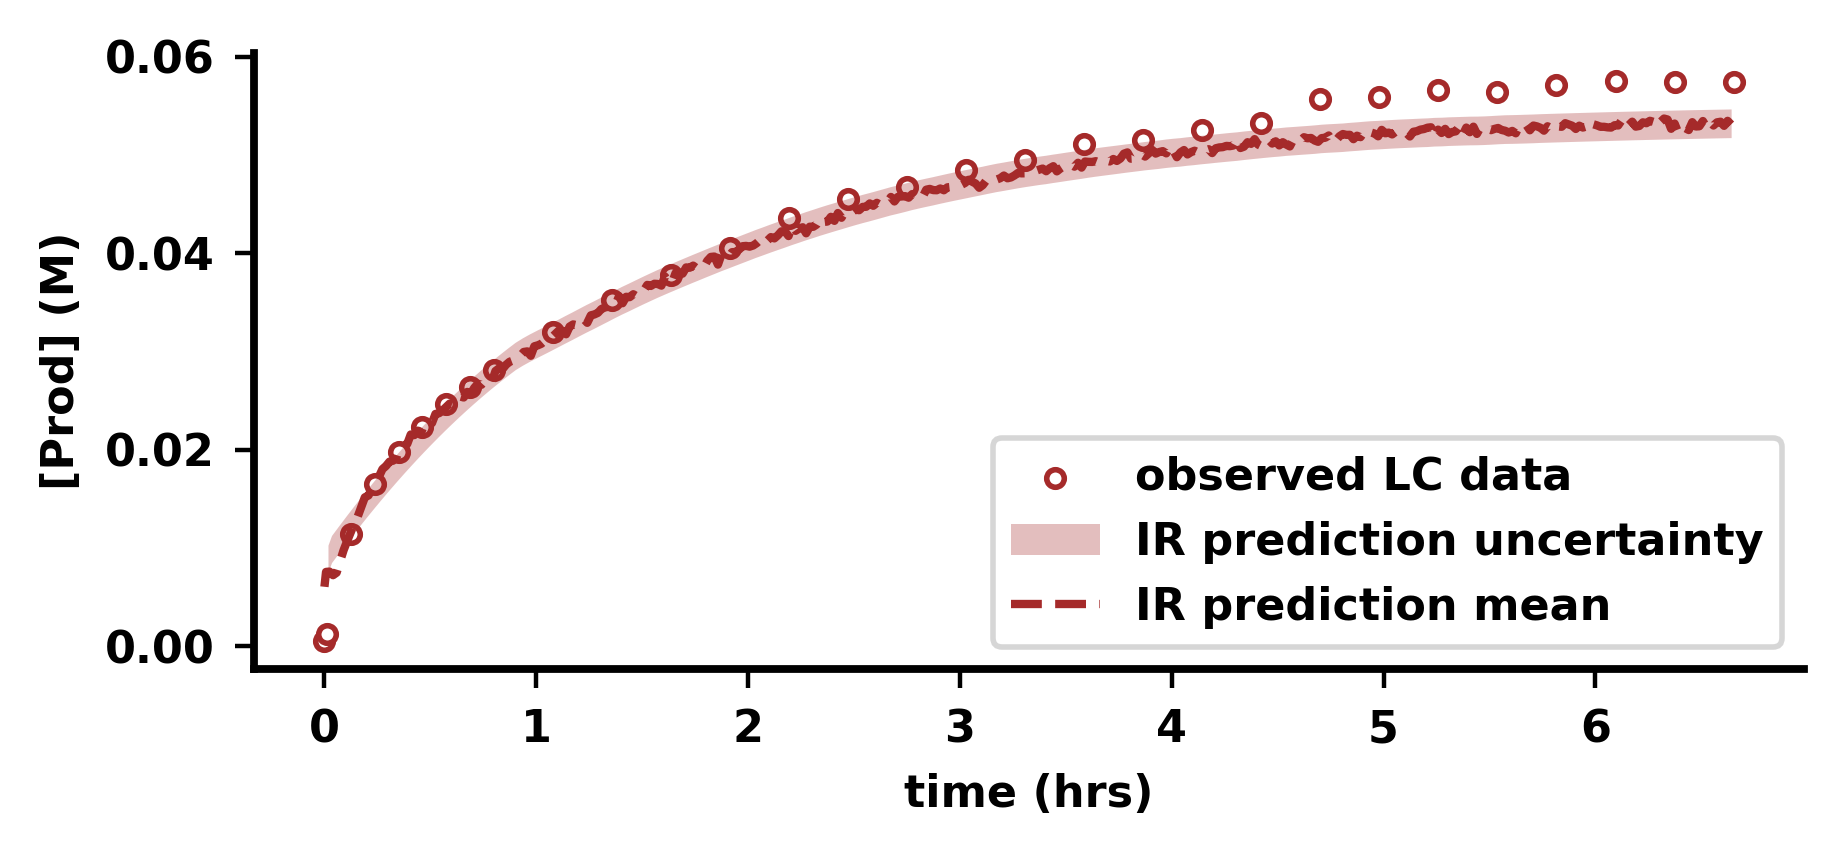

In [18]:
plt.figure(figsize=(5, 2))

mpl.rcParams['font.size'] = 8

x, y = np.array(all_cal_data[test_ind][1]).reshape(-1, 1), np.array(all_cal_data[test_ind][0])
t = ir.lc_data_plot[ir.lc_data_name[test_ind]]['DateTime'].to_numpy()
plt.scatter(t, y, facecolor='w', edgecolor=clist[test_ind], label='observed LC data', s=10)

ir_t = ir.ir_time[test_ind][ir.ir_index_match_lc[test_ind][0]:ir.ir_index_match_lc[test_ind][1]]
az.plot_hdi(ir.ir_time[test_ind][ir.ir_index_match_lc[test_ind][0]:ir.ir_index_match_lc[test_ind][1]],
            temp_idata.posterior_predictive["y_test"], hdi_prob=0.99, fill_kwargs={'alpha':0.3, 'lw':0, 'label':'IR prediction uncertainty', 'color':clist[test_ind]})

avg_posterior = np.mean(temp_idata.posterior_predictive["y_test"].data, axis=0)
avg_posterior_mean = np.mean(avg_posterior, axis=0)

plt.plot(ir_t, avg_posterior_mean, ls='--', c=clist[test_ind], label='IR prediction mean')
plt.xlabel('time (hrs)')
plt.ylabel('[Prod] (M)')
plt.legend()

# Compare the posteriors of response factors for all calibration experiments

In [37]:
# baseline model
with Model() as model: 

    sigma = HalfCauchy("sigma",beta=1)
    slope_1 = Normal("slope_1", 20, sigma=1)
    x1, y1 = all_cal_data[0][1][startpoint:endpoint], all_cal_data[0][0][startpoint:endpoint]

    # for 1-d data, need to make sure that obs is flattened, or otherwise the inference will go bad
    likelihood = Normal('y1', mu=slope_1*x1, sigma=sigma, observed=y1.flatten())

    for i in range(len(all_cal_data)-1): 
        temp_slope = Normal("slope_" + str(i+2), 20, 1)
        x, y = all_cal_data[i+1][1][startpoint:endpoint], all_cal_data[i+1][0][startpoint:endpoint]
        temp_likelihood = Normal('y'+str(i+2), mu=temp_slope*x, sigma=sigma, observed=y.flatten())
        
    idata = sample(chains=4, cores=4)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, slope_1, slope_2, slope_3, slope_4, slope_5, slope_6, slope_7]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 15 seconds.


In [39]:
# amount of anhydride, alochol and TEA added
labels = np.array([[0.13, 0.2, 0.2], [0.2, 0.13, 0.2], [0.2, 0.2, 0.1], [0.1, 0.1, 0], [0.2, 0.1, 0], [0.1, 0.1, 0.2], [0.15, 0.15, 0.1]])

In [40]:
indexs = np.array([i for i in range(7)])[:, np.newaxis]
# pH = labels[:, -1][:, np.newaxis] - labels[:, 0][:, np.newaxis] + labels[:, 1][:, np.newaxis]
pH = labels[:, -1][:, np.newaxis]  # amount of TEA
# pH = np.array([23.5, 24.5, 28.5, 29.5, 29.5, 29.5, 28])[:, np.newaxis]  # temp
# pH = np.array([i+1 for i in range(7)])[:, np.newaxis]
unique_pH = np.unique(pH)
unique_pH = unique_pH[::-1]

# comb = np.hstack((indexs, )
# comb = comb[comb[:, 1].argsort()]

In [41]:
unique_pH = np.unique(pH)
unique_pH = unique_pH[::-1]

In [42]:
hist_xlim_low, hist_xlim_high = 16, 23
x_range = np.linspace(hist_xlim_low, hist_xlim_high, 3000)[:, np.newaxis]
clist = ['b', 'orange', 'g', 'r', 'm', 'brown', 'cyan']

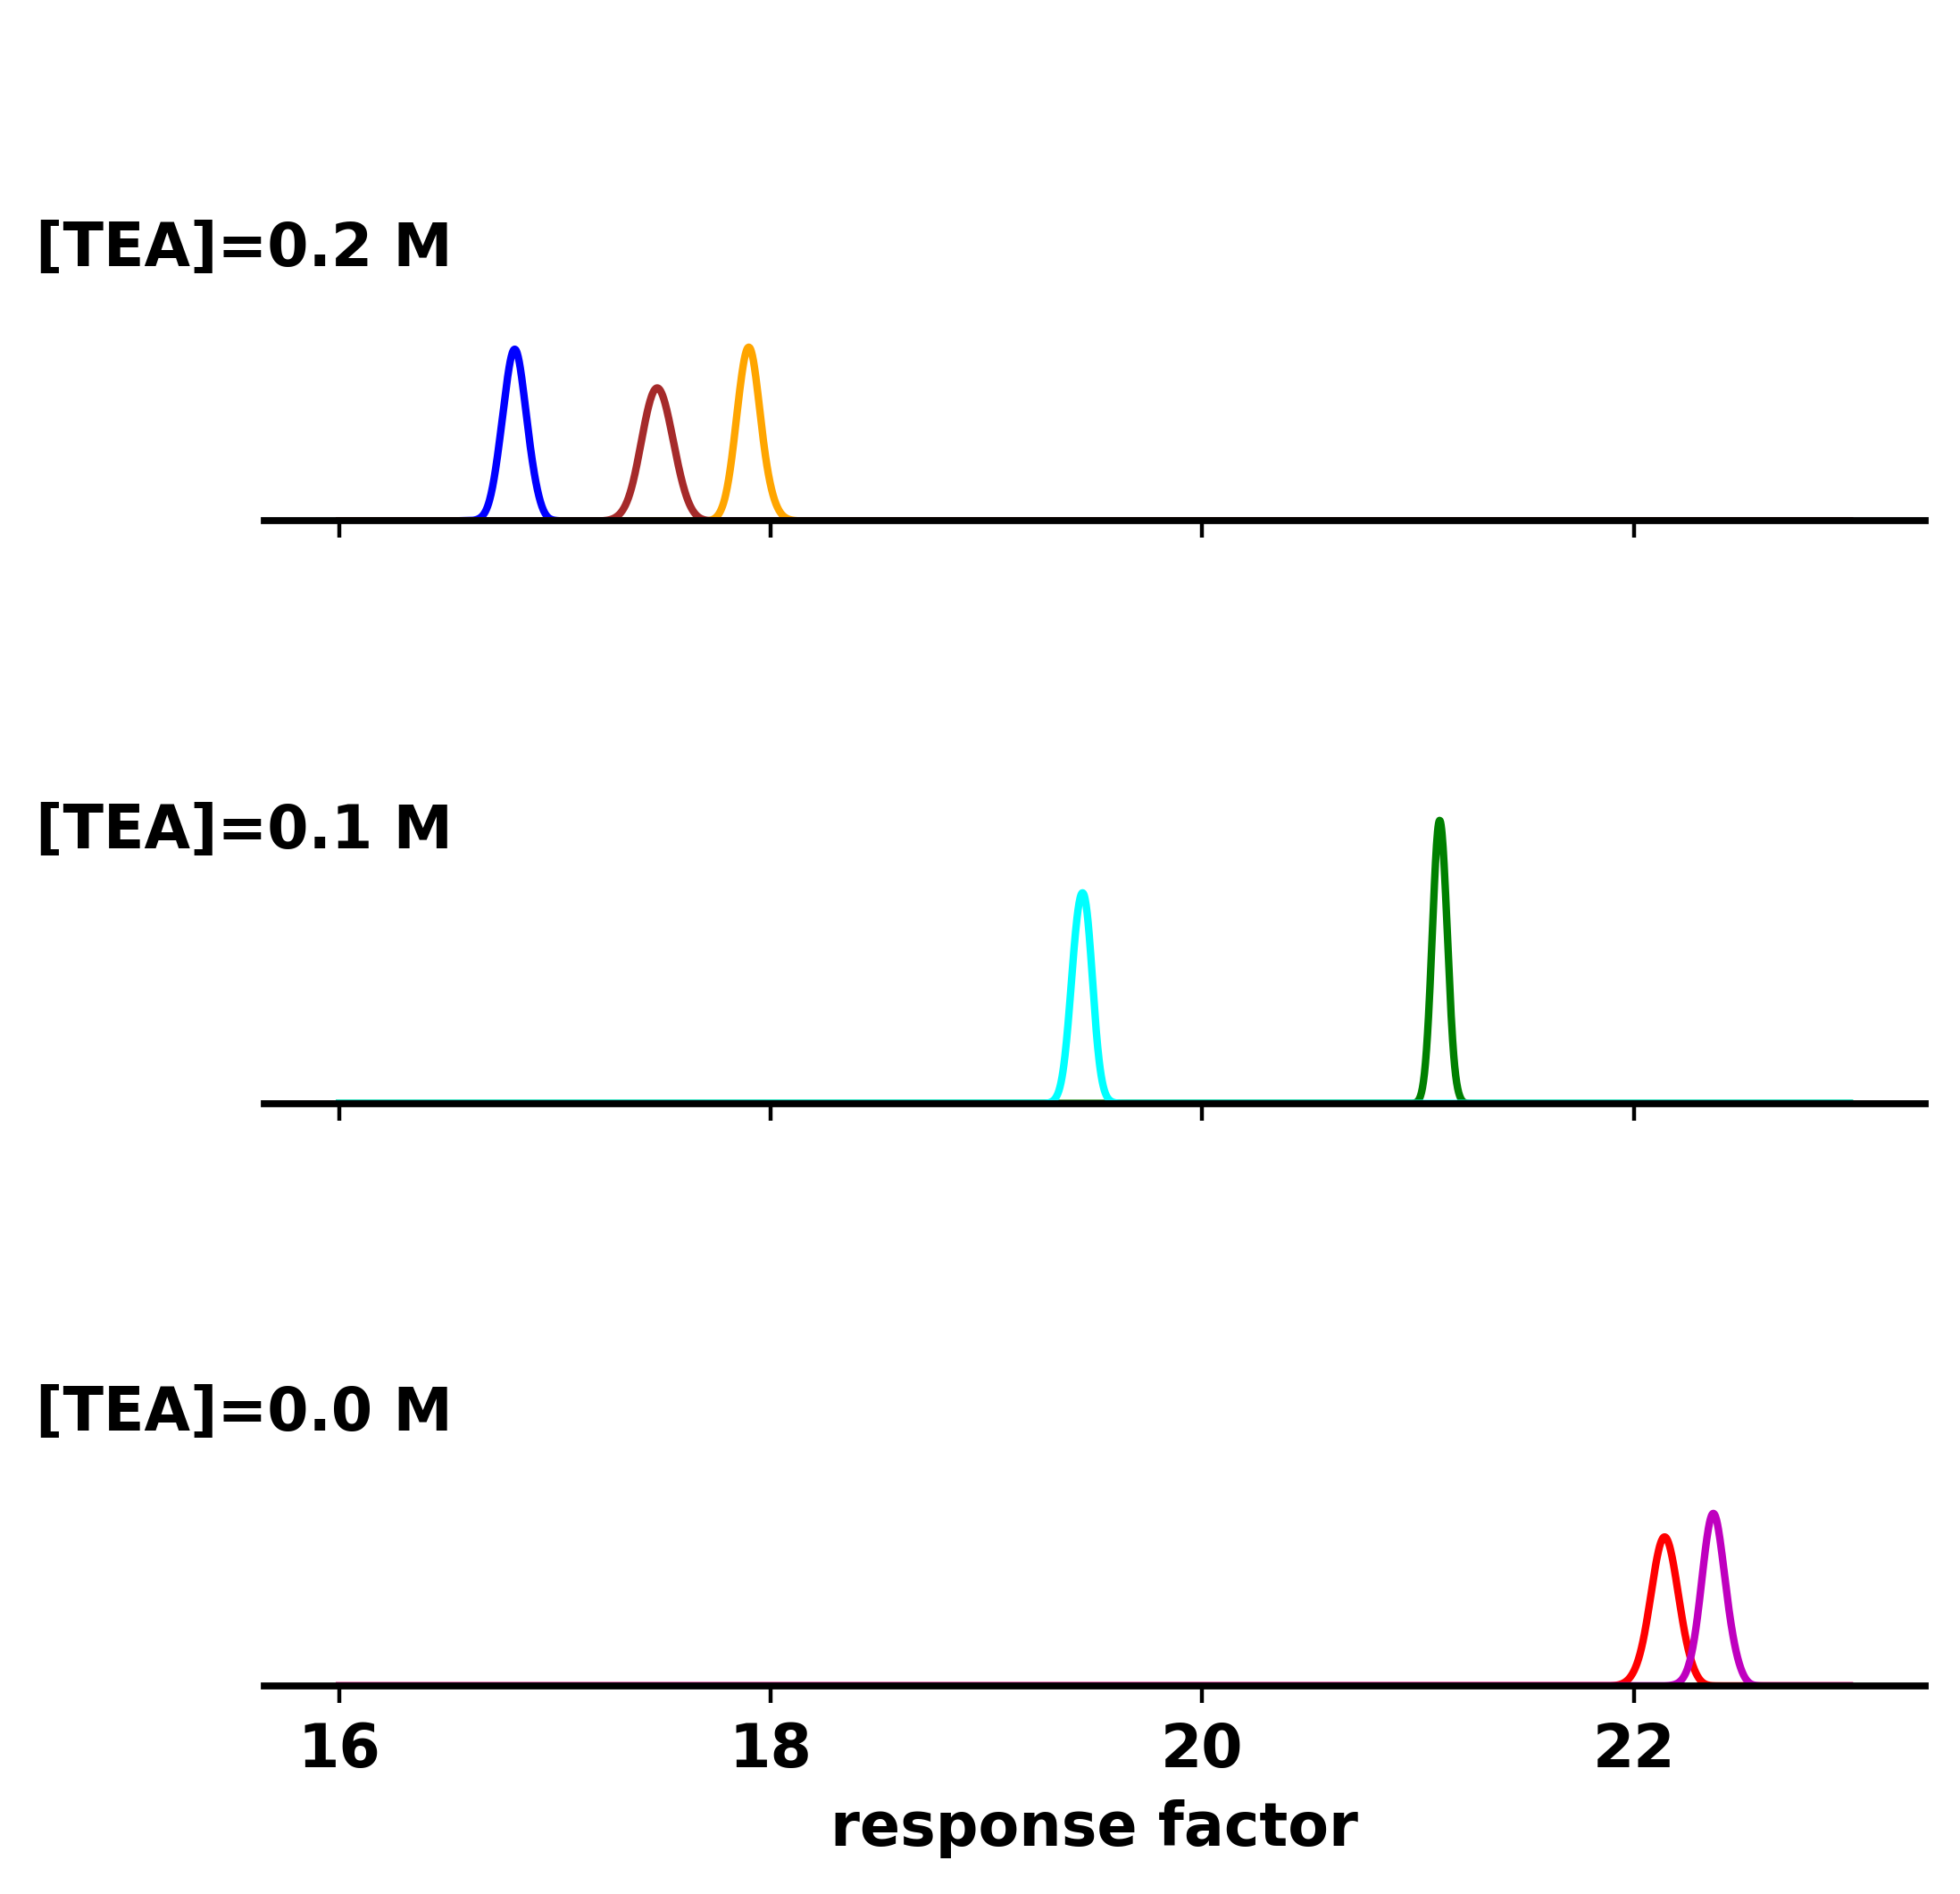

In [48]:
fig, ax = plt.subplots(len(unique_pH), 1, sharex=True, figsize=(6, 6))
mpl.rcParams['font.size'] = 14

posterior_mean = []

for i in range(len(unique_pH)): 

    label = f'[TEA]={unique_pH[i]} M'
    # label = fr'AvgTemp={unique_pH[i]}$^o$C'
    # label = f'[TEA]={unique_pH[i]}'
    # label=f'run order: {unique_pH[i]}'
    
    match_index = np.where(pH == unique_pH[i])[0]
    for ind in match_index: 
        # if ind != 0 and ind != 3 and ind != 6: 
        #     continue

        temp_data = idata.posterior['slope_'+str(ind+1)].data.mean(axis=0)[:, np.newaxis]
        posterior_mean.append(temp_data.mean())
        h = 1.6 * np.std(temp_data) * temp_data.shape[0] ** (-1/7)
    
        kde = KernelDensity(bandwidth=h).fit(temp_data)
        log_dens = kde.score_samples(x_range)
        
        ax[i].plot(x_range, np.exp(log_dens)*2, c=clist[ind], label=f'[TEA]={str(labels[i, -1])}')
        ax[i].set_ylim(0.001, 40)
        # ax[i].hist(temp_data.flatten(), bins=10, 
        #          label=f'[TEA]={str(labels[i, -1])}', color=clist[ind], alpha=0.1)
        
        # ax[i].hist(idata.posterior['slope_'+str(ind+1)].data.mean(axis=0), bins=10, color=clist[ind])
        if i is not len(unique_pH) - 1: 
            # ax[i].spines['bottom'].set_visible(False)
            ax[i].xaxis.set_visible(True)
        else: 
            ax[i].set_xlabel('response factor')
        ax[i].spines['left'].set_visible(False)
        ax[i].set_yticks([])
        ax[i].set_ylabel(label, rotation=0)
